In [2]:
import abc
import glob
import itertools
import json
import os
import re
import shutil
import tarfile
import urllib
import urllib.request
import subprocess
from sklearn import preprocessing
from sklearn.metrics import cohen_kappa_score
import numpy as np
import tempfile
import sys
from logging import getLogger
import pandas as pd
import six
import copy
import random
# import tensorflow.compat.v1 as tf
from distutils.dir_util import copy_tree
from logging import getLogger, StreamHandler, DEBUG
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)
logger.propagate = False
from transformers import AutoTokenizer
from polyleven import levenshtein
from tqdm import tqdm
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

/home/is/kosuke-t/.pyenv/versions/3.8.13/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WMT_LOCATIONS = {'15': {"eval_data": ("DAseg-wmt-newstest2015", 
                                      "DAseg-wmt-newstest2015.tar.gz",
                                      "http://www.computing.dcu.ie/~ygraham/")},
                 '16': {"eval_data": ("DAseg-wmt-newstest2016", 
                                      "DAseg-wmt-newstest2016.tar.gz",
                                      "http://www.computing.dcu.ie/~ygraham/")},
                 '17': {"full_package":("wmt17-metrics-task-no-hybrids", 
                                        "wmt17-metrics-task-package.tgz",
                                        "http://ufallab.ms.mff.cuni.cz/~bojar/")},
                 '18': {"submissions":("wmt18-metrics-task-nohybrids", 
                                       "wmt18-metrics-task-nohybrids.tgz",
                                       "http://ufallab.ms.mff.cuni.cz/~bojar/wmt18/"),
                        "eval_data": ("newstest2018-humaneval", 
                                      "newstest2018-humaneval.tar.gz",
                                      "http://computing.dcu.ie/~ygraham/")},
                 '19': {"submissions": ("wmt19-submitted-data-v3",
                                        "wmt19-submitted-data-v3-txt-minimal.tgz",
                                        "http://ufallab.ms.mff.cuni.cz/~bojar/wmt19/"),
                        "eval_data": ("newstest2019-humaneval", 
                                      "newstest2019-humaneval.tar.gz",
                                      "https://www.computing.dcu.ie/~ygraham/")},
                 '20': {"submissions":("WMT20_data", "", "https://drive.google.com/drive/folders/1n_alr6WFQZfw4dcAmyxow4V8FC67XD8p"), 
                        "eval_data":("wmt20-metrics", "", "https://github.com/WMT-Metrics-task/wmt20-metrics"), 
                        "MQM":("wmt-mqm-human-evaluation", "", "https://github.com/google/wmt-mqm-human-evaluation"), 
                        'PSQM':("wmt-mqm-human-evaluation", "", "https://github.com/google/wmt-mqm-human-evaluation")},
                 '21':{'submissions':("WMT21-data", "", "")},
                 'original':{}}

In [3]:
def separate_lang_pair(lang_pair):
    lang_expr = re.compile("([a-z]{2})-([a-z]{2})")
    match = lang_expr.match(lang_pair)
    if match:
        return match.group(1), match.group(2)
    else:
        return None


def postprocess_segment(segment):
    """Various string post-processing necessary to clean the records."""
    # Identifies NULL values.
    if segment == "NO REFERENCE AVAILABLE\n":
        return None
    # Removes trailing \n's.
    segment = segment.strip()
    return segment

def git_clone(url, destination_path):
    return subprocess.check_call(['git', 'clone', url, destination_path])

In [4]:
@six.add_metaclass(abc.ABCMeta)
class WMTImporter(object):
    """Base class for WMT Importers.

    The aim of WMT importers is to fetch datafiles from the various WMT sources,
    collect information (e.g., list language pairs) and aggregate them into
    one big file.
    """

    def __init__(self, year, target_path, cache_path, args):
        self.year = year
        self.location_info = WMT_LOCATIONS[year]
        self.target_path = target_path
        self.cache_path = cache_path
        self.temp_directory = cache_path
        self.args = args
    
    def open_tar(self, cache_tar_path):
        logger.info("Untaring...")
        tar = tarfile.open(cache_tar_path)
        if self.year == '17':
            self.cache_path = os.path.join(self.cache_path, 'wmt17-metrics-task-package')
            if not os.path.isdir(self.cache_path):
                os.makedirs(self.cache_path)
        tar.extractall(path=self.cache_path)
        tar.close()
        logger.info("Done.")
    
    def fetch_files(self):
        """Downloads raw datafiles from various WMT sources."""
        cache = self.cache_path
        if cache and not os.path.isdir(cache):
            logger.info("Initializing cache {}".format(cache))
            os.makedirs(cache)
        
        for file_type in self.location_info:
            folder_name, archive_name, url_prefix = self.location_info[file_type]
            url = url_prefix + archive_name
            cache_tar_path = os.path.join(cache, archive_name)
            cache_untar_path = os.path.join(cache, archive_name).replace(".tgz", "", 1).replace(".tar.gz", "", 1)
            if cache:
                logger.info("Checking cached tar file {}.".format(cache_tar_path))
                if os.path.exists(cache_untar_path) :
                    logger.info("Cache and untar directory found, skipping")
        #           tf.io.gfile.copy(cache_untar_path, os.path.join(self.temp_directory, os.path.basename(cache_untar_path)), overwrite=True)
                    continue
                if os.path.isfile(cache_tar_path):
                    logger.info("Cache tar file found")
                    self.open_tar(cache_tar_path)

            logger.info("File not found in cache.")
            logger.info("Downloading {} from {}".format(folder_name, url))
            urllib.request.urlretrieve(url, cache_tar_path)
            logger.info("Done.")
            self.open_tar(cache_tar_path)

    def list_lang_pairs(self):
        """List all language pairs included in the WMT files for the target year."""
        pass

    def generate_records_for_lang(self, lang):
        """Consolidates all the files for a given language pair and year."""
        pass

    def cleanup(self):
        """Housekeeping--we want to erase all the temp files created."""
        for file_type in self.location_info:
            folder_name, archive_name, _ = self.location_info[file_type]

            # Removes data folder
            folder_path = os.path.join(self.temp_directory, folder_name)
            logger.info("Removing", folder_path)
            try:
                shutil.rmtree(folder_path)
            except OSError:
                logger.info("OS Error--skipping")

            # Removes downloaded archive
            archive_path = os.path.join(self.temp_directory, archive_name)
            logger.info("Removing", archive_path)
            try:
                os.remove(archive_path)
            except OSError:
                logger.info("OS Error--skipping")

In [5]:
class Importer1516(WMTImporter):
    """Importer for years 2015 and 2016."""

    @staticmethod
    def to_json(year, lang, source, reference, candidate, rating, seg_id, system):
        """Converts record to JSON."""
        json_dict = {"year": int(year),
                     "lang": lang,
                     "source": postprocess_segment(source),
                     "reference": postprocess_segment(reference),
                     "candidate": postprocess_segment(candidate),
                     "raw_rating": None,
                     "rating": float(rating.strip()),
                     "segment_id": seg_id,
                     "system": system,
                     "n_ratings": None}
        return json.dumps(json_dict)

    @staticmethod
    def parse_file_name(fname):
        wmt_pattern = re.compile(r"^DAseg\.newstest([0-9]+)\.[a-z\-]+\.([a-z\-]+)")
        match = re.match(wmt_pattern, fname)
        if match:
            year, lang_pair = int(match.group(1)), match.group(2)
            return year, lang_pair
        else:
            return None, None

    def get_full_folder_path(self):
        """Returns path of directory with all the extracted files."""
        file_type = "eval_data"
        folder_name, _, _ = self.location_info[file_type]
        folder = os.path.join(self.cache_path, folder_name)
        return folder

    def list_files_for_lang(self, lang):
        """Lists the full paths of all the files for a given language pair."""
        year = "20"+self.year
        source_file = "DAseg.newstest{}.source.{}".format(str(year), lang)
        reference_file = "DAseg.newstest{}.reference.{}".format(str(year), lang)
        candidate_file = "DAseg.newstest{}.mt-system.{}".format(str(year), lang)
        rating_file = "DAseg.newstest{}.human.{}".format(str(year), lang)
        folder = self.get_full_folder_path()
        return {"source": os.path.join(folder, source_file),
                "reference": os.path.join(folder, reference_file),
                "candidate": os.path.join(folder, candidate_file),
                "rating": os.path.join(folder, rating_file)}

    def list_lang_pairs(self):
        folder = self.get_full_folder_path()
        file_names = os.listdir(folder)
        file_data = [Importer1516.parse_file_name(f) for f in file_names]
        lang_pairs = [lang_pair for year, lang_pair in file_data if year and lang_pair]
        return list(set(lang_pairs))

    def generate_records_for_lang(self, lang):
        year = '20'+self.year
        input_files = self.list_files_for_lang(lang)

        # pylint: disable=g-backslash-continuation
        with open(input_files["source"], "r", encoding="utf-8") as source_file, \
             open(input_files["reference"], "r", encoding="utf-8") as reference_file, \
             open(input_files["candidate"], "r", encoding="utf-8") as candidate_file, \
             open(input_files["rating"], "r", encoding="utf-8") as rating_file:
            # pylint: enable=g-backslash-continuation
            n_records = 0
            with open(self.target_path, "a+") as dest_file:
                for source, reference, candidate, rating in itertools.zip_longest(
                    source_file, reference_file, candidate_file, rating_file):
                    example = Importer1516.to_json(year, lang, source, reference, candidate, rating, n_records + 1, None)
                    dest_file.write(example)
                    dest_file.write("\n")
                    n_records += 1
                logger.info("Processed {} records of {}'s {}".format(str(n_records), year, lang))
                return n_records


In [6]:
class Importer17(WMTImporter):
    """Importer for year 2017."""

    def __init__(self, *args, **kwargs):
        super(Importer17, self).__init__(*args, **kwargs)
        self.lang_pairs = None
        self.temp_directory = os.path.join(self.cache_path, "wmt17-metrics-task-package")

    def get_folder_path(self):
        """Returns path of directory with all the extracted files."""
        return self.temp_directory

    def agg_ratings_path(self):
        return os.path.join(self.temp_directory, "manual-evaluation", "DA-seglevel.csv")

    def segments_path(self, subset="root"):
        """Return the path to the source, reference, and candidate segments.

        Args:
          subset: one if "root", "source", "reference", or "candidate".

        Returns:
          Path to the relevant folder.
        """
        assert subset in ["root", "source", "reference", "candidate"]
        #     root_dir = os.path.join(self.temp_directory, "extracted_wmt_package")
        root_dir = os.path.join(self.temp_directory, "input")
        if subset == "root":
            return root_dir

        root_dir = os.path.join(root_dir, "wmt17-metrics-task-no-hybrids")
        if subset == "source":
            return os.path.join(root_dir, "wmt17-submitted-data", "txt", "sources")
        elif subset == "reference":
            return os.path.join(root_dir, "wmt17-submitted-data", "txt", "references")
        elif subset == "candidate":
            return os.path.join(root_dir, "wmt17-submitted-data", "txt", "system-outputs", "newstest2017")

    def fetch_files(self):
        """Downloads the WMT eval files."""
        # Downloads the main archive.
        super(Importer17, self).fetch_files()
    
        #Unpacks the segments.
        package_path = self.get_folder_path()
        segments_archive = os.path.join(package_path, "input", "wmt17-metrics-task-no-hybrids.tgz")
        with (tarfile.open(segments_archive, "r:gz")) as tar:
            tar.extractall(path=self.segments_path())
        logger.info("Unpacked the segments to {}.".format(self.segments_path()))

        # Gets the language pair names.
        ratings_path = self.agg_ratings_path()
        lang_pairs = set()
        with open(ratings_path, "r") as ratings_file:
            for l in itertools.islice(ratings_file, 1, None):
                lang = l.split(" ")[0]
                assert re.match("[a-z][a-z]-[a-z][a-z]", lang)
                lang_pairs.add(lang)
        self.lang_pairs = list(lang_pairs)
        logger.info("fetching Done")

    def list_lang_pairs(self):
        """List all language pairs included in the WMT files for the target year."""
        if self.lang_pairs == None:
            ratings_path = self.agg_ratings_path()
            lang_pairs = set()
            with open(ratings_path, "r") as ratings_file:
                for l in itertools.islice(ratings_file, 1, None):
                    lang = l.split(" ")[0]
                    assert re.match("[a-z][a-z]-[a-z][a-z]", lang)
                    lang_pairs.add(lang)
            self.lang_pairs = list(lang_pairs)
        return self.lang_pairs

    def get_ref_segments(self, lang):
        """Fetches source and reference translation segments for language pair."""
        src_subfolder = self.segments_path("source")
        ref_subfolder = self.segments_path("reference")
        src_lang, tgt_lang = separate_lang_pair(lang)
        src_file = "newstest2017-{}{}-src.{}".format(src_lang, tgt_lang, src_lang)
        ref_file = "newstest2017-{}{}-ref.{}".format(src_lang, tgt_lang, tgt_lang)
        src_path = os.path.join(src_subfolder, src_file)
        ref_path = os.path.join(ref_subfolder, ref_file)

#         logger.info("Reading data from files {} and {}".format(src_path, ref_path))
        with open(src_path, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        with open(ref_path, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()
        src_segments = [postprocess_segment(s) for s in src_segments]
        ref_segments = [postprocess_segment(s) for s in ref_segments]
#         logger.info("Read {} source and {} reference segments.".format(len(src_segments), len(ref_segments)))
        return src_segments, ref_segments

    @staticmethod
    def parse_submission_file_name(fname):
        """Extracts system names from the name of submission files."""
        wmt_pattern = re.compile(r"^newstest2017\.([a-zA-Z0-9\-\.]+\.[0-9]+)\.[a-z]{2}-[a-z]{2}")
        match = re.match(wmt_pattern, fname)
        if match:
            return match.group(1)
        else:
            return None

    def get_sys_segments(self, lang):
        """Builds a dictionary with the generated segments for each system."""
        # Gets all submission file paths.
        root_folder = self.segments_path("candidate")
        folder = os.path.join(root_folder, lang)
        all_files = os.listdir(folder)
#         logger.info("Reading submission files from {}".format(folder))

        # Extracts the generated segments for each submission.
        sys_segments = {}
        for sys_file_name in all_files:
            sys_name = Importer17.parse_submission_file_name(sys_file_name)
            assert sys_name
            sys_path = os.path.join(folder, sys_file_name)
            with open(sys_path, "r", encoding="utf-8") as f_sys:
                sys_lines = f_sys.readlines()
                sys_lines = [postprocess_segment(s) for s in sys_lines]
                sys_segments[sys_name] = sys_lines

#         logger.info("Read submissions from {} systems".format(len(sys_segments.keys())))
        return sys_segments

    def parse_rating(self, line):
        fields = line.split()
        lang = fields[0]
        sys_names = fields[2].split("+")
        seg_id = int(fields[3])
        z_score = float(fields[4])
        raw_score = None
        for sys_name in sys_names:
            yield lang, sys_name, seg_id, raw_score, z_score

    def generate_records_for_lang(self, lang):
        """Consolidates all the files for a given language pair and year."""
        # Loads source, reference and system segments.
        src_segments, ref_segments = self.get_ref_segments(lang)
        sys_segments = self.get_sys_segments(lang)

        # Streams the rating file and performs the join on-the-fly.
        ratings_file_path = self.agg_ratings_path()
#         logger.info("Reading file {}".format(ratings_file_path))
        n_records = 0
        with open(ratings_file_path, "r", encoding="utf-8") as f_ratings:
            with open(self.target_path, "a+") as dest_file:
                for line in itertools.islice(f_ratings, 1, None):
                    for parsed_line in self.parse_rating(line):
                        line_lang, sys_name, seg_id, raw_score, z_score = parsed_line
                        if line_lang != lang:
                            continue
                        # The "-1" is necessary because seg_id starts counting at 1.
                        src_segment = src_segments[seg_id - 1]
                        ref_segment = ref_segments[seg_id - 1]
                        sys_segment = sys_segments[sys_name][seg_id - 1]
                        example = Importer18.to_json('20'+self.year, lang, src_segment,
                                                     ref_segment, sys_segment, raw_score,
                                                     z_score, seg_id, sys_name)
                        dest_file.write(example)
                        dest_file.write("\n")
                        n_records += 1
        logger.info("Processed {} records of {}'s {}".format(str(n_records), self.year, lang))
        return n_records

In [7]:
class Importer18(WMTImporter):
    """Importer for year 2018."""

    def parse_submission_file_name(self, fname):
        """Extracts system names from the name of submission files."""
        wmt_pattern = re.compile(r"^newstest2018\.([a-zA-Z0-9\-\.]+\.[0-9]+)\.[a-z]{2}-[a-z]{2}")
        match = re.match(wmt_pattern, fname)
        if match:
            return match.group(1)
        else:
            return None

    def parse_eval_file_name(self, fname):
        """Extracts language pairs from the names of human rating files."""
        wmt_pattern = re.compile(r"^ad-seg-scores-([a-z]{2}-[a-z]{2})\.csv")
        match = re.match(wmt_pattern, fname)
        if match:
            return match.group(1)
        else:
            return None

    def list_lang_pairs(self):
        """List all language pairs included in the WMT files for 2018."""
        folder_name, _, _ = self.location_info["eval_data"]
        subfolder = "analysis"
        folder = os.path.join(self.temp_directory, folder_name, subfolder)
        all_files = os.listdir(folder)
        cand_lang_pairs = [self.parse_eval_file_name(fname) for fname in all_files]
        # We need to remove None values in cand_lang_pair:
        lang_pairs = [lang_pair for lang_pair in cand_lang_pairs if lang_pair]
        return list(set(lang_pairs))

    def get_ref_segments(self, lang):
        """Fetches source and reference translation segments for language pair."""
        folder, _, _ = self.location_info["submissions"]
        src_subfolder = os.path.join("sources")
        ref_subfolder = os.path.join("references")
        src_lang, tgt_lang = separate_lang_pair(lang)
        src_file = "newstest2018-{}{}-src.{}".format(src_lang, tgt_lang, src_lang)
        ref_file = "newstest2018-{}{}-ref.{}".format(src_lang, tgt_lang, tgt_lang)
        src_path = os.path.join(self.temp_directory, folder, src_subfolder, src_file)
        ref_path = os.path.join(self.temp_directory, folder, ref_subfolder, ref_file)

#         logger.info("Reading data from files {} and {}".format(src_path, ref_path))
        with open(src_path, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        with open(ref_path, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()

        src_segments = [postprocess_segment(s) for s in src_segments]
        ref_segments = [postprocess_segment(s) for s in ref_segments]

        return src_segments, ref_segments

    def get_sys_segments(self, lang):
        """Builds a dictionary with the generated segments for each system."""
        # Gets all submission file paths.
        folder_name, _, _ = self.location_info["submissions"]
        subfolder = os.path.join("system-outputs", "newstest2018")
        folder = os.path.join(self.temp_directory, folder_name, subfolder, lang)
        all_files = os.listdir(folder)
#         logger.info("Reading submission files from {}".format(folder))

        # Extracts the generated segments for each submission.
        sys_segments = {}
        for sys_file_name in all_files:
            if sys_file_name == '.ipynb_checkpoints':
                continue
            sys_name = self.parse_submission_file_name(sys_file_name)
            assert sys_name
            sys_path = os.path.join(folder, sys_file_name)
            with open(sys_path, "r", encoding="utf-8") as f_sys:
                sys_lines = f_sys.readlines()
                sys_lines = [postprocess_segment(s) for s in sys_lines]
                sys_segments[sys_name] = sys_lines

        return sys_segments

    def get_ratings_path(self, lang):
        folder, _, _ = self.location_info["eval_data"]
        subfolder = "analysis"
        file_name = "ad-seg-scores-{}.csv".format(lang)
        return os.path.join(self.temp_directory, folder, subfolder, file_name)

    def parse_rating(self, rating_line):
        rating_tuple = tuple(rating_line.split(" "))
        # I have a feeling that the last field is the number of ratings
        # but I'm not 100% sure .
        sys_name, seg_id, raw_score, z_score, n_ratings = rating_tuple
        seg_id = int(seg_id)
        raw_score = float(raw_score)
        z_score = float(z_score)
        n_ratings = int(n_ratings)
        return sys_name, seg_id, raw_score, z_score, n_ratings

    @staticmethod
    def to_json(year, lang, src_segment, ref_segment, sys_segment,
                raw_score, z_score, seg_id, sys_name, n_ratings=0):
        """Converts record to JSON."""
        json_dict = {"year": year, "lang": lang, "source": src_segment, 
                     "reference": ref_segment, "candidate": sys_segment, "raw_rating": raw_score,
                     "rating": z_score, "segment_id": seg_id, "system": sys_name,
                     "n_ratings": n_ratings}
        return json.dumps(json_dict)

    def generate_records_for_lang(self, lang):
        """Consolidates all the files for a given language pair and year."""

        # Loads source, reference and system segments.
        src_segments, ref_segments = self.get_ref_segments(lang)
        sys_segments = self.get_sys_segments(lang)

        # Streams the rating file and performs the join on-the-fly.
        ratings_file_path = self.get_ratings_path(lang)
#         logger.info("Reading file {}".format(ratings_file_path))
        n_records = 0
        with open(ratings_file_path, "r", encoding="utf-8") as f_ratings:
            with open(self.target_path, "a+") as dest_file:
                for line in itertools.islice(f_ratings, 1, None):
                    line = line.rstrip()
                    parsed_tuple = self.parse_rating(line)
                    sys_name, seg_id, raw_score, z_score, n_ratings = parsed_tuple

                    # Those weird rules come from the WMT 2019 DA2RR script.
                    # Name of the script: seglevel-ken-rr.py, in Metrics results package.
                    if sys_name == "UAlacant_-_NM":
                        sys_name = "UAlacant_-_NMT+RBMT.6722"
                    if sys_name == "HUMAN":
                        continue
                    if sys_name == "RBMT.6722":
                        continue

                    # The following rules were added by me to unblock WMT2019:
                    if sys_name == "Helsinki-NLP.6889":
                        sys_name = "Helsinki_NLP.6889"
                    if sys_name == "Facebook-FAIR.6937":
                        sys_name = "Facebook_FAIR.6937"
                    if sys_name == "Facebook-FAIR.6937":
                        sys_name = "Facebook_FAIR.6937"
                    if sys_name == "DBMS-KU-KKEN.6726":
                        sys_name = "DBMS-KU_KKEN.6726"
                    if sys_name == "Ju-Saarland.6525":
                        sys_name = "Ju_Saarland.6525"
                    if sys_name == "aylien-mt-gu-en-multilingual.6826":
                        sys_name = "aylien_mt_gu-en_multilingual.6826"
                    if sys_name == "rug-kken-morfessor.6677":
                        sys_name = "rug_kken_morfessor.6677"
                    if sys_name == "talp-upc-2019-kken.6657":
                        sys_name = "talp_upc_2019_kken.6657"
                    if sys_name == "Frank-s-MT.6127":
                        sys_name = "Frank_s_MT.6127"

                    if lang == "de-cs" and sys_name == "Unsupervised.6935":
                        sys_name = "Unsupervised.de-cs.6935"
                    if lang == "de-cs" and sys_name == "Unsupervised.6929":
                        sys_name = "Unsupervised.de-cs.6929"

                    # The "-1" is necessary because seg_id starts counting at 1.
                    src_segment = src_segments[seg_id - 1]
                    ref_segment = ref_segments[seg_id - 1]
                    sys_segment = sys_segments[sys_name][seg_id - 1]
                    if not src_segment or not sys_segment:
                        logger.info("* Missing value!")
                        logger.info("* System: {}".format(sys_name))
                        logger.info("* Segment:" + str(seg_id))
                        logger.info("* Source segment:" + src_segment)
                        logger.info("* Sys segment:" + sys_segment)
                        logger.info("* Parsed line:" + line)
                        logger.info("* Lang:" + lang)
                    example = Importer18.to_json(self.year, lang, src_segment, 
                                                 ref_segment, sys_segment, raw_score, 
                                                 z_score, seg_id, sys_name, n_ratings)
                    dest_file.write(example)
                    dest_file.write("\n")
                    n_records += 1
        logger.info("Processed {} records of {}'s {}".format(str(n_records), self.year, lang))
        return n_records


In [8]:
class Importer19(Importer18):
    """Importer for WMT19 Metrics challenge."""

    def parse_rating(self, rating_line):
        rating_tuple = tuple(rating_line.split(" "))
        # I have a feeling that the last field is the number of ratings
        # but I'm not 100% sure.
        sys_name, seg_id, raw_score, z_score, n_ratings = rating_tuple

        # For some reason, all the systems for pair zh-en have an extra suffix.
        if sys_name.endswith("zh-en"):
            sys_name = sys_name[:-6]

        seg_id = int(seg_id)
        raw_score = float(raw_score)
        z_score = float(z_score)
        n_ratings = int(n_ratings)
        return sys_name, seg_id, raw_score, z_score, n_ratings

    def parse_submission_file_name(self, fname):
        """Extracts system names from the name of submission files."""

        # I added those rules to unblock the pipeline.
        if fname == "newstest2019.Unsupervised.de-cs.6929.de-cs":
            return "Unsupervised.de-cs.6929"
        elif fname == "newstest2019.Unsupervised.de-cs.6935.de-cs":
            return "Unsupervised.de-cs.6935"

        wmt_pattern = re.compile(r"^newstest2019\.([a-zA-Z0-9\-\.\_\+]+\.[0-9]+)\.[a-z]{2}-[a-z]{2}")
        match = re.match(wmt_pattern, fname)
        if match:
            return match.group(1)
        else:
            return None

    def list_lang_pairs(self):
        """List all language pairs included in the WMT files for 2019."""
        folder_name, _, _ = self.location_info["eval_data"]
        folder = os.path.join(self.temp_directory, folder_name, "*", "analysis", "ad-seg-scores-*.csv")
        all_full_paths = glob.glob(folder)
        all_files = [os.path.basename(f) for f in all_full_paths]
        cand_lang_pairs = [self.parse_eval_file_name(fname) for fname in all_files]
        # We need to remove None values in cand_lang_pair:
        lang_pairs = [lang_pair for lang_pair in cand_lang_pairs if lang_pair]
        return list(set(lang_pairs))

    def get_ratings_path(self, lang):
        folder, _, _ = self.location_info["eval_data"]

        # The pair zh-en has two versions in the WMT 2019 human eval folder.
        if lang == "zh-en":
            path = os.path.join(self.temp_directory, folder, 
                                "turkle-sntlevel-humaneval-newstest2019", "analysis", "ad-seg-scores-zh-en.csv")
            return path

        file_name = "ad-seg-scores-{}.csv".format(lang)
        folder = os.path.join(self.temp_directory, folder, "*", "analysis", "ad-seg-scores-*.csv")
        all_files = glob.glob(folder)
        for cand_file in all_files:
            if cand_file.endswith(file_name):
                return cand_file
        raise ValueError("Can't find ratings for lang {}".format(lang))

    def get_ref_segments(self, lang):
        """Fetches source and reference translation segments for language pair."""
        folder, _, _ = self.location_info["submissions"]
        src_subfolder = os.path.join("txt", "sources")
        ref_subfolder = os.path.join("txt", "references")
        src_lang, tgt_lang = separate_lang_pair(lang)
        src_file = "newstest2019-{}{}-src.{}".format(src_lang, tgt_lang, src_lang)
        ref_file = "newstest2019-{}{}-ref.{}".format(src_lang, tgt_lang, tgt_lang)
        src_path = os.path.join(self.temp_directory, folder, src_subfolder, src_file)
        ref_path = os.path.join(self.temp_directory, folder, ref_subfolder, ref_file)

#         logger.info("Reading data from files {} and {}".format(src_path, ref_path))
        with open(src_path, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        with open(ref_path, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()

        src_segments = [postprocess_segment(s) for s in src_segments]
        ref_segments = [postprocess_segment(s) for s in ref_segments]

        return src_segments, ref_segments

    def get_sys_segments(self, lang):
        """Builds a dictionary with the generated segments for each system."""
        # Gets all submission file paths.
        folder_name, _, _ = self.location_info["submissions"]
        subfolder = os.path.join("txt", "system-outputs", "newstest2019")
        folder = os.path.join(self.temp_directory, folder_name, subfolder, lang)
        all_files = os.listdir(folder)
#         logger.info("Reading submission files from {}".format(folder))

        # Extracts the generated segments for each submission.
        sys_segments = {}
        for sys_file_name in all_files:
            sys_name = self.parse_submission_file_name(sys_file_name)
            assert sys_name
            sys_path = os.path.join(folder, sys_file_name)
            with open(sys_path, "r", encoding="utf-8") as f_sys:
                sys_lines = f_sys.readlines()
                sys_lines = [postprocess_segment(s) for s in sys_lines]
                sys_segments[sys_name] = sys_lines

        return sys_segments

In [9]:
class Importer20(Importer18):
    """Importer for WMT20 Metrics challenge."""
    
    def __init__(self, year, target_path, cache_path, args, include_unreliables, onlyMQM=False, onlyPSQM=False):
        super(Importer20, self).__init__(year, target_path, cache_path, args)
        self.include_unreliables = include_unreliables
        self.onlyMQM = onlyMQM
        self.onlyPSQM = onlyPSQM
        self.args = args
        assert not (onlyMQM and onlyPSQM), "only one of onlyMQM or onlyPSQM can stand"
    
    def open_tar(self, tar_path, open_dir):
        logger.info("Untaring...")
        tar = tarfile.open(tar_path)
        tar.extractall(path=open_dir)
        tar.close()
        logger.info("Done.")
    
    def fetch_files(self):
        """Downloads raw datafiles from various WMT sources."""
        cache = self.cache_path
        
        if cache and not os.path.isdir(cache):
            logger.info("Initializing cache {}".format(cache))
            os.makedirs(cache)
        
        for file_type in self.location_info:
            if self.onlyMQM:
                if file_type in ['submissions', 'eval_data', 'PSQM']:
                    continue
            elif self.onlyPSQM:
                if file_type in ['submissions', 'eval_data', 'MQM']:
                    continue
            
            folder_name, _, url = self.location_info[file_type]
            cache_untar_path = os.path.join(cache, folder_name)
            
            if cache:
                logger.info("Checking cached tar file {}.".format(cache_untar_path))
                if os.path.exists(cache_untar_path) :
                    if file_type == 'submissions':
                        tars = os.path.join(cache_untar_path, '*.tar.gz')
                        tar_paths = glob.glob(tars)
                        untar_paths = [path.replace(".tar.gz", "", 1) for path in tar_paths]
                        for tar_path, untar_paths in zip(tar_paths, untar_paths):
                            if not os.path.exists(untar_paths):
                                self.open_tar(tar_path, cache_untar_path)
                            else:
                                logger.info("Cache and untar directory found, skipping")
                    else:
                        logger.info("Cache and untar directory found, skipping")
                    continue
            logger.info("File not found in cache.")
            if file_type == 'submissions':
                logger.info("Cannot download {} with this script. Download from {}".format(folder_name, url))
                exit(-1)
            logger.info("Downloading {} from {}".format(folder_name, url))
            git_clone(url, cache_untar_path)
            logger.info("Done.")  
    
    def parse_rating(self, rating_line, lang):
        rating_tuple = tuple(rating_line.split(" "))
        # I have a feeling that the last field is the number of ratings
        # but I'm not 100% sure.
        sys_name, seg_id, raw_score, z_score, n_ratings = rating_tuple
        
        # en-zh has unknown seg_id probablly tagged with other format name
        if lang in ['en-zh', 'en-ja', 'en-iu', 'en-cs', 'en-ta', 'en-ru', 'en-de', 'en-pl']:
            seg_id = seg_id.split('_')[-1] 
        
        try:
            seg_id = int(seg_id)
            raw_score = float(raw_score)
            z_score = float(z_score)
            n_ratings = int(n_ratings)
        except:
            logger.info(lang)
            logger.info(rating_line)
        return sys_name, seg_id, raw_score, z_score, n_ratings

    def parse_submission_file_name(self, fname, lang):
        """Extracts system names from the name of submission files."""

        # I added those rules to unblock the pipeline.

        sys_name = fname.replace("newstest2020.{}.".format(lang), "", 1).replace(".txt", "", 1)

        return sys_name

    def list_lang_pairs(self):
        """List all language pairs included in the WMT files for 2020."""
        if self.onlyMQM or self.onlyPSQM:
            return ['en-de', 'zh-en']
        
        folder_name, _, _ = self.location_info["eval_data"]
        folder = os.path.join(self.temp_directory, folder_name, "manual-evaluation", "DA", "ad-seg-scores-*.csv")
        all_full_paths = glob.glob(folder)
        all_files = [os.path.basename(f) for f in all_full_paths]
        cand_lang_pairs = [self.parse_eval_file_name(fname) for fname in all_files]
        # We need to remove None values in cand_lang_pair:
        lang_pairs = [lang_pair for lang_pair in cand_lang_pairs if lang_pair]
        return list(set(lang_pairs))

    def get_ratings_path(self, lang):
        folder, _, _ = self.location_info["eval_data"]

        file_name = "ad-seg-scores-{}.csv".format(lang)
        folder = os.path.join(self.temp_directory, folder, "manual-evaluation", "DA", "ad-seg-scores-*.csv")
        all_files = glob.glob(folder)
        for cand_file in all_files:
            if cand_file.endswith(file_name):
                return cand_file
        raise ValueError("Can't find ratings for lang {}".format(lang))

    def get_ref_segments(self, lang):
        """Fetches source and reference translation segments for language pair."""
        folder, _, _ = self.location_info["submissions"]
        src_subfolder = os.path.join("txt", "sources")
        ref_subfolder = os.path.join("txt", "references")
        src_lang, tgt_lang = separate_lang_pair(lang)
        src_file = "newstest2020-{}{}-src.{}.txt".format(src_lang, tgt_lang, src_lang)
        ref_file = "newstest2020-{}{}-ref.{}.txt".format(src_lang, tgt_lang, tgt_lang)
        src_path = os.path.join(self.temp_directory, folder, src_subfolder, src_file)
        ref_path = os.path.join(self.temp_directory, folder, ref_subfolder, ref_file)

#         logger.info("Reading data from files {} and {}".format(src_path, ref_path))
        with open(src_path, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        with open(ref_path, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()

        src_segments = [postprocess_segment(s) for s in src_segments]
        ref_segments = [postprocess_segment(s) for s in ref_segments]

        return src_segments, ref_segments

    def get_sys_segments(self, lang):
        """Builds a dictionary with the generated segments for each system."""
        # Gets all submission file paths.
        folder_name, _, _ = self.location_info["submissions"]
        subfolder = os.path.join("txt", "system-outputs")
        folder = os.path.join(self.temp_directory, folder_name, subfolder, lang)
        all_files = os.listdir(folder)
#         logger.info("Reading submission files from {}".format(folder))

        # Extracts the generated segments for each submission.
        sys_segments = {}
        for sys_file_name in all_files:
            sys_name = self.parse_submission_file_name(sys_file_name, lang)
            assert sys_name
            sys_path = os.path.join(folder, sys_file_name)
            with open(sys_path, "r", encoding="utf-8") as f_sys:
                sys_lines = f_sys.readlines()
                sys_lines = [postprocess_segment(s) for s in sys_lines]
                sys_segments[sys_name] = sys_lines

        return sys_segments
    
    def parse_mqm(self, line, lang):
        rating_tuple = tuple(line.split("\t"))
        system, doc, doc_id, seg_id, rater, source, target, category, severity = rating_tuple
        
        score = 0.0
        assert severity in ['Major', 'Minor', 'Neutral', 'no-error'], 'unknown severity:{}'.format(severity)

        if severity == 'Major':
            if category == 'Non-translation!':
                score = -25.0
            else:
                score = -5.0
        elif severity == 'Minor':
            if category == 'Fluency/Punctuation':
                score = -0.1
            else:
                score = -1.0
        
        try:
            doc_id = int(doc_id)
            seg_id = int(seg_id)
        except:
            logger.info(lang)
            logger.info(line)
        return system, doc, doc_id, seg_id, rater, source, target, category, severity, score
    
    def get_mqm_segments(self, lang):
        src_lang, tgt_lang = separate_lang_pair(lang)
        folder_name, _, _ = self.location_info["MQM"]
        file = os.path.join(self.temp_directory, folder_name, "{}{}".format(src_lang, tgt_lang), "mqm_newstest2020_{}{}.tsv".format(src_lang, tgt_lang))
        rater_score = {}
        seg_scores = {}
        with open(file, mode='r', encoding='utf-8') as r:
            for line in itertools.islice(r, 1, None):
                line = line.rstrip()
                system, doc, doc_id, seg_id, rater, source, target, category, severity, score = self.parse_mqm(line, lang)
                if rater not in rater_score:
                    rater_score[rater] = {'score':[score], 
                                          'source':[source.rstrip()],
                                          'target':[target.rstrip()], 
                                          'system':[system], 
                                          'seg_id':[seg_id]}
                else:
                    rater_score[rater]['score'].append(score)
                    rater_score[rater]['source'].append(source.rstrip())
                    rater_score[rater]['target'].append(target.rstrip())
                    rater_score[rater]['system'].append(system)
                    rater_score[rater]['seg_id'].append(seg_id)
        for rater in rater_score.keys():
            rater_score[rater]['z_score'] = list(preprocessing.scale(rater_score[rater]['score']))
        for rater in rater_score.keys():
            for seg_id, src, tgt, score, z_score, system in zip(rater_score[rater]['seg_id'], 
                                                                rater_score[rater]['source'], 
                                                                rater_score[rater]['target'], 
                                                                rater_score[rater]['score'], 
                                                                rater_score[rater]['z_score'], 
                                                                rater_score[rater]['system']):
                sys_id = (system, seg_id)
                if sys_id not in seg_scores:
                    seg_scores[sys_id] = {'rater':[rater],
                                          'score':[score], 
                                          'z_score':[z_score],
                                          'source':[source],
                                          'target':[target]}
                else:
                    seg_scores[sys_id]['rater'].append(rater)
                    seg_scores[sys_id]['score'].append(score)
                    seg_scores[sys_id]['z_score'].append(z_score)
                    seg_scores[sys_id]['source'].append(source)
                    seg_scores[sys_id]['target'].append(target)
        for sys_id in seg_scores.keys():
            seg_scores[sys_id]['z_mean_score'] = np.mean(seg_scores[sys_id]['z_score'])
            
        return rater_score, seg_scores
                
    def get_mqm_avg_segments(self, lang, seg_scores):
        src_lang, tgt_lang = separate_lang_pair(lang)
        folder_name, _, _ = self.location_info["MQM"]
        file = os.path.join(self.temp_directory, folder_name, "{}{}".format(src_lang, tgt_lang), "mqm_newstest2020_{}{}.avg_seg_scores.tsv".format(src_lang, tgt_lang))
        with open(file, mode='r', encoding='utf-8') as r:
            for line in itertools.islice(r, 1, None):
                line = line.rstrip()
                system, mqm_avg_score, seg_id = tuple(line.split(' '))
                sys_id = (system, int(seg_id))
                seg_scores[sys_id]['raw_score'] = mqm_avg_score
        return seg_scores
    
    def generate_mqm_records_for_lang(self, lang):
        rater_score, seg_scores = self.get_mqm_segments(lang)
        src_segments, ref_segments = self.get_ref_segments(lang)
        sys_segments = self.get_sys_segments(lang)
        seg_scores = self.get_mqm_avg_segments(lang, seg_scores)
        
        n_records = 0
        skipped_n_records = 0
        with open(self.target_path, "a+") as dest_file:
            for sys_id in seg_scores.keys():
                sys_name, seg_id = sys_id
                raw_score = seg_scores[sys_id]['raw_score']
                z_score = seg_scores[sys_id]['z_score']
                
                # The "-1" is necessary because seg_id starts counting at 1.
                src_segment = src_segments[seg_id - 1]
                ref_segment = ref_segments[seg_id - 1]
                if sys_name not in sys_segments:
                    logger.info(sys_name, lang)
                else:
                    sys_segment = sys_segments[sys_name][seg_id - 1]

                if not src_segment or not sys_segment:
                    logger.info("* Missing value!")
                    logger.info("* System: {}".format(sys_name))
                    logger.info("* Segment:" + str(seg_id))
                    logger.info("* Source segment:" + src_segment)
                    logger.info("* Sys segment:" + sys_segment)
                    logger.info("* Parsed line:" + line)
                    logger.info("* Lang:" + lang)
                example = self.to_json(self.year, lang, src_segment, 
                                             ref_segment, sys_segment, raw_score, 
                                             z_score, seg_id, sys_name)
                dest_file.write(example)
                dest_file.write("\n")
                n_records += 1
        logger.info("Processed {} records of {}'s {}".format(str(n_records), self.year, lang))
        logger.info("Skipped {} records of {}'s {}".format(str(skipped_n_records), self.year, lang))
        return n_records
    
    def parse_psqm(self, line, lang):
        rating_tuple = tuple(line.split("\t"))
        system, doc, doc_id, seg_id, rater, source, target, score = rating_tuple
        
        score = 0.0
        try:
            doc_id = int(doc_id)
            seg_id = int(seg_id)
        except:
            logger.info(lang)
            logger.info(line)
        return system, doc, doc_id, seg_id, rater, source, target, score
    
    def get_psqm_segments(self, lang):
        src_lang, tgt_lang = separate_lang_pair(lang)
        folder_name, _, _ = self.location_info["PSQM"]
        file = os.path.join(self.temp_directory, folder_name, "{}{}".format(src_lang, tgt_lang), "psqm_newstest2020_{}{}.tsv".format(src_lang, tgt_lang))
        rater_score = {}
        seg_scores = {}
        with open(file, mode='r', encoding='utf-8') as r:
            for line in itertools.islice(r, 1, None):
                line = line.rstrip()
                system, doc, doc_id, seg_id, rater, source, target, score = self.parse_psqm(line, lang)
                if rater not in rater_score:
                    rater_score[rater] = {'score':[score], 
                                          'source':[source.rstrip()],
                                          'target':[target.rstrip()], 
                                          'system':[system], 
                                          'seg_id':[seg_id]}
                else:
                    rater_score[rater]['score'].append(score)
                    rater_score[rater]['source'].append(source.rstrip())
                    rater_score[rater]['target'].append(target.rstrip())
                    rater_score[rater]['system'].append(system)
                    rater_score[rater]['seg_id'].append(seg_id)
        for rater in rater_score.keys():
            rater_score[rater]['z_score'] = list(preprocessing.scale(rater_score[rater]['score']))
        for rater in rater_score.keys():
            for seg_id, src, tgt, score, z_score, system in zip(rater_score[rater]['seg_id'], 
                                                                rater_score[rater]['source'], 
                                                                rater_score[rater]['target'], 
                                                                rater_score[rater]['score'], 
                                                                rater_score[rater]['z_score'], 
                                                                rater_score[rater]['system']):
                sys_id = (system, seg_id)
                if sys_id not in seg_scores:
                    seg_scores[sys_id] = {'rater':[rater],
                                          'score':[score], 
                                          'z_score':[z_score],
                                          'source':[source],
                                          'target':[target]}
                else:
                    seg_scores[sys_id]['rater'].append(rater)
                    seg_scores[sys_id]['score'].append(score)
                    seg_scores[sys_id]['z_score'].append(z_score)
                    seg_scores[sys_id]['source'].append(source)
                    seg_scores[sys_id]['target'].append(target)
        for sys_id in seg_scores.keys():
            seg_scores[sys_id]['z_mean_score'] = np.mean(seg_scores[sys_id]['z_score'])
        
        return rater_score, seg_scores
    
    
    def generate_psqm_records_for_lang(self, lang):
        rater_score, seg_scores = self.get_psqm_segments(lang)
        src_segments, ref_segments = self.get_ref_segments(lang)
        sys_segments = self.get_sys_segments(lang)
        
        n_records = 0
        skipped_n_records = 0
        with open(self.target_path, "a+") as dest_file:
            for sys_id in seg_scores.keys():
                sys_name, seg_id = sys_id
                raw_score = 'n/a'
                z_score = seg_scores[sys_id]['z_score']
                
                # The "-1" is necessary because seg_id starts counting at 1.
                src_segment = src_segments[seg_id - 1]
                ref_segment = ref_segments[seg_id - 1]
                if sys_name not in sys_segments:
                    logger.info(sys_name, lang)
                else:
                    sys_segment = sys_segments[sys_name][seg_id - 1]

                if not src_segment or not sys_segment:
                    logger.info("* Missing value!")
                    logger.info("* System: {}".format(sys_name))
                    logger.info("* Segment:" + str(seg_id))
                    logger.info("* Source segment:" + src_segment)
                    logger.info("* Sys segment:" + sys_segment)
                    logger.info("* Parsed line:" + line)
                    logger.info("* Lang:" + lang)
                example = self.to_json(self.year, lang, src_segment, 
                                             ref_segment, sys_segment, raw_score, 
                                             z_score, seg_id, sys_name)
                dest_file.write(example)
                dest_file.write("\n")
                n_records += 1
        logger.info("Processed {} records of {}'s {}".format(str(n_records), self.year, lang))
        logger.info("Skipped {} records of {}'s {}".format(str(skipped_n_records), self.year, lang))
        
        return n_records
    
    def to_json(self, year, lang, src_segment, ref_segment, sys_segment,
                raw_score, z_score, seg_id, sys_name, n_ratings=0):
        """Converts record to JSON."""
        if self.args.use_avg_seg_scores and (self.args.onlyMQM or self.args.onlyPSQM): 
            json_dict = {"year": year, "lang": lang, "source": src_segment, 
                         "reference": ref_segment, "candidate": sys_segment, "z_rating": z_score,
                         "rating": raw_score, "segment_id": seg_id, "system": sys_name,
                         "n_ratings": n_ratings}
            return json.dumps(json_dict)
        else:
            json_dict = {"year": year, "lang": lang, "source": src_segment, 
                         "reference": ref_segment, "candidate": sys_segment, "raw_rating": raw_score,
                         "rating": z_score, "segment_id": seg_id, "system": sys_name,
                         "n_ratings": n_ratings}
            return json.dumps(json_dict)
    
    def generate_records_for_lang(self, lang):
        """Consolidates all the files for a given language pair and year."""
        
        if self.onlyMQM:
            n_records = self.generate_mqm_records_for_lang(lang)
            return n_records
        elif self.onlyPSQM:
            n_records = self.generate_psqm_records_for_lang(lang)
            return n_records
        
        if self.args.priorMQM == False :
            raise NotImplementedError
        # if lang in ['en-de', 'zh-en']:
        #     _, MQMsegments = self.get_mqm_segments(lang)
        
        
        # Loads source, reference and system segments.
        src_segments, ref_segments = self.get_ref_segments(lang)
        sys_segments = self.get_sys_segments(lang)

        # Streams the rating file and performs the join on-the-fly.
        ratings_file_path = self.get_ratings_path(lang)
#         logger.info("Reading file {}".format(ratings_file_path))
        n_records = 0
        skipped_n_records = 0
        
        if lang in ['en-zh', 'en-ja', 'en-iu', 'en-cs', 'en-ta', 'en-ru', 'en-de', 'en-pl'] and (not self.include_unreliables):
            return 0
        
        with open(ratings_file_path, "r", encoding="utf-8") as f_ratings:
            with open(self.target_path, "a+") as dest_file:
                for line in itertools.islice(f_ratings, 1, None):
                    line = line.rstrip()
                    parsed_tuple = self.parse_rating(line, lang)
                    sys_name, seg_id, raw_score, z_score, n_ratings = parsed_tuple
                    
                    if sys_name == 'HUMAN.0' and lang == 'de-en':
                        skipped_n_records += 1
                        continue
                    if sys_name == 'HUMAN.0' and lang == 'zh-en':
                        skipped_n_records += 1
                        continue
                    if sys_name == 'HUMAN.0' and lang == 'ru-en':
                        skipped_n_records += 1
                        continue
                    if sys_name == 'HUMAN-B':
                        sys_name == 'Human-B.0'
                    if sys_name == 'Huoshan-Translate.1470' and lang == 'ps-en':
                        sys_name = 'Huoshan_Translate.1470'
                    if sys_name == 'Facebook-AI.729' and lang == 'iu-en':
                        sys_name = 'Facebook_AI.729'
                    if sys_name == 'Huawei-TSC.1533' and lang == 'ps-en':
                        sys_name = 'Huawei_TSC.1533'
                    if sys_name == 'UQAM-TanLe.520' and lang == 'iu-en':
                        sys_name = 'UQAM_TanLe.520'
                    if sys_name == 'HUMAN' and lang == 'ps-en':
                        sys_name = 'Human-A.0'
                    if sys_name == 'NICT-Kyoto.1220' and lang == 'iu-en':
                        sys_name = 'NICT_Kyoto.1220'
                    if sys_name == 'HUMAN' and lang == 'iu-en':
                        sys_name = 'Human-A.0'
                    if sys_name == 'Huawei-TSC.1539' and lang == 'km-en':
                        sys_name = 'Huawei_TSC.1539'
                    if sys_name == 'Huoshan-Translate.651' and lang == 'km-en':
                        sys_name = 'Huoshan_Translate.651'
                    if sys_name == 'HUMAN' and lang == 'km-en':
                        sys_name = 'Human-A.0'
                    
                    if self.args.priorMQM and self.args.onlyDA == False and lang in ['en-de', 'zh-en']:
                        if (sys_name, seg_id) in MQMsegments:
                            skipped_n_records += 1
                            continue
                    
                    # The "-1" is necessary because seg_id starts counting at 1.
                    src_segment = src_segments[seg_id - 1]
                    ref_segment = ref_segments[seg_id - 1]
                    sys_segment = sys_segments[sys_name][seg_id - 1]
                    
                    if not src_segment or not sys_segment:
                        logger.info("* Missing value!")
                        logger.info("* System: {}".format(sys_name))
                        logger.info("* Segment:" + str(seg_id))
                        logger.info("* Source segment:" + src_segment)
                        logger.info("* Sys segment:" + sys_segment)
                        logger.info("* Parsed line:" + line)
                        logger.info("* Lang:" + lang)
                    example = Importer18.to_json(self.year, lang, src_segment, 
                                                 ref_segment, sys_segment, raw_score, 
                                                 z_score, seg_id, sys_name, n_ratings)
                    dest_file.write(example)
                    dest_file.write("\n")
                    n_records += 1
        logger.info("Processed {} records of {}'s {}".format(str(n_records), self.year, lang))
        logger.info("Skipped {} records of {}'s {}".format(str(skipped_n_records), self.year, lang))
        return n_records
    
    
    

In [10]:
class Importer21(Importer18):
    """Importer for WMT20 Metrics challenge."""
    
    def __init__(self, year, target_path, cache_path, args):
        super(Importer21, self).__init__(year, target_path, cache_path, args)
        self.args = args
        self.tasks = ['challengeset', 'florestest2021', 'newstest2021', 'tedtalks']
    
    def open_tar(self, tar_path, open_dir):
        logger.info("Untaring...")
        tar = tarfile.open(tar_path)
        tar.extractall(path=open_dir)
        tar.close()
        logger.info("Done.")
    
    def fetch_files(self):
        """Downloads raw datafiles from various WMT sources."""
        return
    
    def parse_rating(self, rating_line, lang):
        rating_tuple = tuple(rating_line.split(" "))
        # I have a feeling that the last field is the number of ratings
        # but I'm not 100% sure.
        sys_name, seg_id, raw_score, z_score, n_ratings = rating_tuple
        
        # en-zh has unknown seg_id probablly tagged with other format name
#         if lang in ['en-zh', 'en-ja', 'en-iu', 'en-cs', 'en-ta', 'en-ru', 'en-de', 'en-pl']:
#             seg_id = seg_id.split('_')[-1] 
        try:
            seg_id = int(seg_id)
            raw_score = float(raw_score)
            z_score = float(z_score)
            n_ratings = int(n_ratings)
        except:
            logger.info(lang)
            logger.info(rating_line)
        return sys_name, seg_id, raw_score, z_score, n_ratings

    def parse_submission_file_name(self, fname, lang, task):
        """Extracts system names from the name of submission files."""

        # I added those rules to unblock the pipeline.

        sys_name = fname.replace("{}.{}.{}.".format(task, lang, 'hyp'), "", 1).replace(".{}".format(lang.split('-')[-1]), "", 1)

        return sys_name
    
    def parse_source_file_name(self, fname, task):
        lang = fname.replace("{}.".format(task), "")
        return lang[:5]
    
    def list_lang_pairs(self, task):
        """List all language pairs included in the WMT files for 2020."""
        
        folder_name, _, _ = self.location_info["submissions"]
        folder = os.path.join(self.temp_directory, folder_name, 'sources', '*')
        all_full_paths = glob.glob(folder)
        all_files = [os.path.basename(f) for f in all_full_paths if os.path.basename(f).startswith(task)]
        cand_lang_pairs = [self.parse_source_file_name(fname, task) for fname in all_files]
        # We need to remove None values in cand_lang_pair:
        lang_pairs = [lang_pair for lang_pair in cand_lang_pairs if lang_pair]
        return list(set(lang_pairs))

    def get_ratings_path(self, lang, task):
        folder, _, _ = self.location_info["eval_data"]

        file_name = "ad-seg-scores-{}.csv".format(lang)
        folder = os.path.join(self.temp_directory, folder, "manual-evaluation", "DA", "ad-seg-scores-*.csv")
        all_files = glob.glob(folder)
        for cand_file in all_files:
            if cand_file.endswith(file_name):
                return cand_file
        raise ValueError("Can't find ratings for lang {}".format(lang))

    def get_src_segments(self, lang, task):
        """Fetches source translation segments for language pair."""
        folder, _, _ = self.location_info["submissions"]
        src_lang, tgt_lang = separate_lang_pair(lang)
        src_subfolder = 'sources'
        src_file = "{}.{}-{}.src.{}".format(task, src_lang, tgt_lang, src_lang)
        src_path = os.path.join(self.temp_directory, folder, src_subfolder, src_file)
        with open(src_path, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()

        src_segments = [postprocess_segment(s) for s in src_segments]
        
        return src_segments
    
    def get_ref_segments(self, lang, task):
        """Fetches source and reference translation segments for language pair."""
        folder, _, _ = self.location_info["submissions"]
        src_lang, tgt_lang = separate_lang_pair(lang)
        ref_subfolder = 'references'
        ref_files = {}
        ref_files['ref-A'] = "{}.{}-{}.ref.ref-A.{}".format(task, src_lang, tgt_lang, tgt_lang)
        ref_files['ref-B'] = "{}.{}-{}.ref.ref-B.{}".format(task, src_lang, tgt_lang, tgt_lang)
        ref_files['ref-C'] = "{}.{}-{}.ref.ref-C.{}".format(task, src_lang, tgt_lang, tgt_lang)
        ref_files['ref-D'] = "{}.{}-{}.ref.ref-D.{}".format(task, src_lang, tgt_lang, tgt_lang)
        ref_paths = {ref_id:os.path.join(self.temp_directory, folder, ref_subfolder, ref_files[ref_id]) for ref_id in ref_files.keys()}
        ref_segments = {}
        for ref_id in ref_paths.keys():
            if os.path.isfile(ref_paths[ref_id]):
                with open(ref_paths[ref_id], "r", encoding="utf-8") as f_ref:
                    ref_segments[ref_id] = f_ref.readlines()
                    
        ref_segments = {ref_id:[postprocess_segment(s) for s in ref_segments[ref_id]] for ref_id in ref_segments.keys()}
        return ref_segments

    def get_sys_segments(self, lang, task):
        """Builds a dictionary with the generated segments for each system."""
        # Gets all submission file paths.
        folder_name, _, _ = self.location_info["submissions"]
        subfolder = os.path.join("system-outputs", task)
        folder = os.path.join(self.temp_directory, folder_name, subfolder, lang)
        all_files = os.listdir(folder)
#         logger.info("Reading submission files from {}".format(folder))

        # Extracts the generated segments for each submission.
        sys_segments = {}
        for sys_file_name in all_files:
            sys_name = self.parse_submission_file_name(sys_file_name, lang, task)
            assert sys_name
            if sys_name.startswith(task):
                continue
            sys_path = os.path.join(folder, sys_file_name)
            with open(sys_path, "r", encoding="utf-8") as f_sys:
                sys_lines = f_sys.readlines()
                sys_lines = [postprocess_segment(s) for s in sys_lines]
                sys_segments[sys_name] = sys_lines

        return sys_segments
    
    
    def check_dic(self, ref, sys, ref_dic, sys_dic):
        if ref not in ref_dic:
            ref_dic[ref] = 1
        else:
            ref_dic[ref] += 1
        if sys not in sys_dic:
            sys_dic[sys] = 1
        else:
            sys_dic[sys] += 1
        return ref_dic, sys_dic
    
    def to_json(self, year, lang, src_segment, ref_segment, ref_id, sys_segment,
                raw_score, z_score, seg_id, sys_name, n_ratings=0):
        """Converts record to JSON."""
        json_dict = {"year": year, "lang": lang, "source": src_segment, 
                     "reference": ref_segment, "ref_id":ref_id, "candidate": sys_segment, "raw_score": raw_score,
                     "score": z_score, "segment_id": seg_id, "system": sys_name,
                     "n_ratings": n_ratings}
        return json.dumps(json_dict)
    
    def generate_records_for_lang(self, lang, task, ref_dic, sys_dic):
        """Consolidates all the files for a given language pair and year."""
        # Loads source, reference and system segments.
        src_segments = self.get_src_segments(lang, task)
        ref_segments = self.get_ref_segments(lang, task)
        sys_segments = self.get_sys_segments(lang, task)
    
        # Streams the rating file and performs the join on-the-fly.
#         ratings_file_path = self.get_ratings_path(lang)
#         logger.info("Reading file {}".format(ratings_file_path))
        n_records = 0
        skipped_n_records = 0
#         if lang in ['en-zh', 'en-ja', 'en-iu', 'en-cs', 'en-ta', 'en-ru', 'en-de', 'en-pl'] and (not self.include_unreliables):
#             return 0
        with open(self.target_path, "a+") as dest_file:
            for sys_name in sys_segments.keys():
                for seg_id in range(len(src_segments)):
                    if len(ref_segments) > 1:
                        if lang != 'en-de':
                            ref_id1 = list(ref_segments.keys())[0]
                            ref_id2 = list(ref_segments.keys())[1]
                            src_segment = src_segments[seg_id]
                            ref_segment = ref_segments[ref_id1][seg_id]
                            sys_segment = sys_segments[sys_name][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id1, sys_segment, 0.0, 
                                                         0.0, seg_id+1, sys_name, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id1, sys_name, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id2, sys_segment, 0.0, 
                                                         0.0, seg_id+1, sys_name, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id2, sys_name, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id1][seg_id]
                            sys_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id1, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id2, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id1, ref_id2, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id2][seg_id]
                            sys_segment = ref_segments[ref_id1][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id2, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id1, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id2, ref_id1, ref_dic, sys_dic)
                        else:
                            ref_id1 = list(ref_segments.keys())[0]
                            ref_id2 = list(ref_segments.keys())[1]
                            ref_id3 = list(ref_segments.keys())[2]
                            ref_id4 = list(ref_segments.keys())[3]
                            src_segment = src_segments[seg_id]
                            ref_segment = ref_segments[ref_id1][seg_id]
                            sys_segment = sys_segments[sys_name][seg_id]
                            ####
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id1, sys_segment, 0.0, 
                                                         0.0, seg_id+1, sys_name, 0)
                            
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id1, sys_name, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id2, sys_segment, 0.0, 
                                                         0.0, seg_id+1, sys_name, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id2, sys_name, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id3, sys_segment, 0.0, 
                                                         0.0, seg_id+1, sys_name, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id3, sys_name, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id4, sys_segment, 0.0, 
                                                         0.0, seg_id+1, sys_name, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id4, sys_name, ref_dic, sys_dic)
                            #####
                            ref_segment = ref_segments[ref_id1][seg_id]
                            sys_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id1, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id2, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id1, ref_id2, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id1][seg_id]
                            sys_segment = ref_segments[ref_id3][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id1, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id3, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id1, ref_id3, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id1][seg_id]
                            sys_segment = ref_segments[ref_id4][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id1, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id4, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id1, ref_id4, ref_dic, sys_dic)
                            ####
                            ref_segment = ref_segments[ref_id2][seg_id]
                            sys_segment = ref_segments[ref_id1][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id2, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id1, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id2, ref_id1, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id2][seg_id]
                            sys_segment = ref_segments[ref_id3][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id2, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id3, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id2, ref_id3, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id2][seg_id]
                            sys_segment = ref_segments[ref_id4][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id2, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id4, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id2, ref_id4, ref_dic, sys_dic)
                            
                            #####
                            ref_segment = ref_segments[ref_id3][seg_id]
                            sys_segment = ref_segments[ref_id1][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id3, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id1, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id3, ref_id1, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id3][seg_id]
                            sys_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id3, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id2, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id3, ref_id2, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id3][seg_id]
                            sys_segment = ref_segments[ref_id4][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id3, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id4, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id3, ref_id4, ref_dic, sys_dic)
                            #####
                            ref_segment = ref_segments[ref_id4][seg_id]
                            sys_segment = ref_segments[ref_id1][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id4, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id1, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id4, ref_id1, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id4][seg_id]
                            sys_segment = ref_segments[ref_id2][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id4, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id2, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id4, ref_id2, ref_dic, sys_dic)
                            
                            ref_segment = ref_segments[ref_id4][seg_id]
                            sys_segment = ref_segments[ref_id3][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id4, sys_segment, 0.0, 
                                                         0.0, seg_id+1, ref_id3, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id4, ref_id3, ref_dic, sys_dic)
                    else:
                        ref_id = list(ref_segments.keys())[0]
                        src_segment = src_segments[seg_id]
                        ref_segment = ref_segments[ref_id][seg_id]
                        sys_segment = sys_segments[sys_name][seg_id]
                        example = self.to_json(self.year, lang, src_segment, 
                                                     ref_segment, ref_id, sys_segment, 0.0, 
                                                     0.0, seg_id+1, sys_name, 0)
                        dest_file.write(example)
                        dest_file.write("\n")
                        n_records += 1
                        ref_dic, sys_dic = self.check_dic(ref_id, sys_name, ref_dic, sys_dic)
#         logger.info("Processed {} records of {}'s {}".format(str(n_records), self.year, lang))
#         logger.info("Skipped {} records of {}'s {}".format(str(skipped_n_records), self.year, lang))
        return n_records, ref_dic, sys_dic

    def generate_records(self, task, ref_dic, sys_dic):
        """Consolidates all the files for a given language pair and year."""
        n_records = 0
        skipped_n_records = 0
        with open(self.target_path, "w") as dest_file:
            for lang in importer.list_lang_pairs(task):
                logger.info('{}, {}'.format(lang, task))
                # Loads source, reference and system segments.
                src_segments = self.get_src_segments(lang, task)
                ref_segments = self.get_ref_segments(lang, task)
                sys_segments = self.get_sys_segments(lang, task)

            # Streams the rating file and performs the join on-the-fly.
    #         ratings_file_path = self.get_ratings_path(lang)
    #         logger.info("Reading file {}".format(ratings_file_path))


    #         if lang in ['en-zh', 'en-ja', 'en-iu', 'en-cs', 'en-ta', 'en-ru', 'en-de', 'en-pl'] and (not self.include_unreliables):
    #             return 0

                for sys_name in sys_segments.keys():
                    for seg_id in range(len(src_segments)):
                        if len(ref_segments) > 1:
                            if lang != 'en-de':
                                ref_id1 = list(ref_segments.keys())[0]
                                ref_id2 = list(ref_segments.keys())[1]
                                src_segment = src_segments[seg_id]
                                ref_segment = ref_segments[ref_id1][seg_id]
                                sys_segment = sys_segments[sys_name][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id1, sys_segment, 0.0, 
                                                             0.0, seg_id+1, sys_name, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id1, sys_name, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id2, sys_segment, 0.0, 
                                                             0.0, seg_id+1, sys_name, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id2, sys_name, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id1][seg_id]
                                sys_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id1, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id2, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id1, ref_id2, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id2][seg_id]
                                sys_segment = ref_segments[ref_id1][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id2, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id1, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id2, ref_id1, ref_dic, sys_dic)
                            else:
                                ref_id1 = list(ref_segments.keys())[0]
                                ref_id2 = list(ref_segments.keys())[1]
                                ref_id3 = list(ref_segments.keys())[2]
                                ref_id4 = list(ref_segments.keys())[3]
                                src_segment = src_segments[seg_id]
                                ref_segment = ref_segments[ref_id1][seg_id]
                                sys_segment = sys_segments[sys_name][seg_id]
                                ####
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id1, sys_segment, 0.0, 
                                                             0.0, seg_id+1, sys_name, 0)

                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id1, sys_name, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id2, sys_segment, 0.0, 
                                                             0.0, seg_id+1, sys_name, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id2, sys_name, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id3, sys_segment, 0.0, 
                                                             0.0, seg_id+1, sys_name, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id3, sys_name, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id4, sys_segment, 0.0, 
                                                             0.0, seg_id+1, sys_name, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id4, sys_name, ref_dic, sys_dic)
                                #####
                                ref_segment = ref_segments[ref_id1][seg_id]
                                sys_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id1, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id2, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id1, ref_id2, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id1][seg_id]
                                sys_segment = ref_segments[ref_id3][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id1, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id3, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id1, ref_id3, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id1][seg_id]
                                sys_segment = ref_segments[ref_id4][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id1, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id4, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id1, ref_id4, ref_dic, sys_dic)
                                ####
                                ref_segment = ref_segments[ref_id2][seg_id]
                                sys_segment = ref_segments[ref_id1][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id2, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id1, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id2, ref_id1, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id2][seg_id]
                                sys_segment = ref_segments[ref_id3][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id2, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id3, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id2, ref_id3, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id2][seg_id]
                                sys_segment = ref_segments[ref_id4][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id2, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id4, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id2, ref_id4, ref_dic, sys_dic)

                                #####
                                ref_segment = ref_segments[ref_id3][seg_id]
                                sys_segment = ref_segments[ref_id1][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id3, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id1, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id3, ref_id1, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id3][seg_id]
                                sys_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id3, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id2, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id3, ref_id2, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id3][seg_id]
                                sys_segment = ref_segments[ref_id4][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id3, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id4, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id3, ref_id4, ref_dic, sys_dic)
                                #####
                                ref_segment = ref_segments[ref_id4][seg_id]
                                sys_segment = ref_segments[ref_id1][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id4, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id1, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id4, ref_id1, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id4][seg_id]
                                sys_segment = ref_segments[ref_id2][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id4, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id2, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id4, ref_id2, ref_dic, sys_dic)

                                ref_segment = ref_segments[ref_id4][seg_id]
                                sys_segment = ref_segments[ref_id3][seg_id]
                                example = self.to_json(self.year, lang, src_segment, 
                                                             ref_segment, ref_id4, sys_segment, 0.0, 
                                                             0.0, seg_id+1, ref_id3, 0)
                                dest_file.write(example)
                                dest_file.write("\n")
                                n_records += 1
                                ref_dic, sys_dic = self.check_dic(ref_id4, ref_id3, ref_dic, sys_dic)
                        else:
                            ref_id = list(ref_segments.keys())[0]
                            src_segment = src_segments[seg_id]
                            ref_segment = ref_segments[ref_id][seg_id]
                            sys_segment = sys_segments[sys_name][seg_id]
                            example = self.to_json(self.year, lang, src_segment, 
                                                         ref_segment, ref_id, sys_segment, 0.0, 
                                                         0.0, seg_id+1, sys_name, 0)
                            dest_file.write(example)
                            dest_file.write("\n")
                            n_records += 1
                            ref_dic, sys_dic = self.check_dic(ref_id, sys_name, ref_dic, sys_dic)
        return n_records, ref_dic, sys_dic


In [11]:
class ImporterOriginal(Importer21):
    def __init__(self, year, target_path, cache_path, args):
        super(Importer21, self).__init__(year, target_path, cache_path, args)
        self.args = args
    
    def generate_records_for_lang(self, src_file, ref_file, hyp_file, lang):
        src_segments = []
        ref_segments = []
        hyp_segments = []
        
        with open(src_file, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        src_segments = [postprocess_segment(s) for s in src_segments]
        
        with open(ref_file, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()
        ref_segments = [postprocess_segment(s) for s in ref_segments]
        
        with open(hyp_file, "r", encoding="utf-8") as f_hyp:
            hyp_segments = f_hyp.readlines()
        hyp_segments = [postprocess_segment(s) for s in hyp_segments]
        
        assert len(src_segments) == len(ref_segments) and len(src_segments) == len(hyp_segments)
        n_records = 0
        with open(self.target_path, "a+") as dest_file:
            for i in range(len(src_segments)):
                seg_id = i + 1
                # year, lang, src_segment, ref_segment, ref_id, sys_segment,
                # raw_score, z_score, seg_id, sys_name, n_ratings=0
                example = self.to_json(self.year, lang, src_segments[i], ref_segments[i], 'ref-A', hyp_segments[i], 
                                       0.0, 0.0, seg_id, '', 0)
                dest_file.write(example)
                dest_file.write("\n")
                n_records += 1

In [6]:
class Importer21_DA():
    def __init__(self, save_dir, wo_MQM=True):
        self.wo_MQM = wo_MQM
        if wo_MQM:
            save_dir = save_dir.replace('.json', '_wo_MQM.json')
        self.save_dir = save_dir
        self.save_tmp = save_dir + '_tmp'
        self.DA21_HOME_DIR = '/home/is/kosuke-t/project_disc/WMT/wmt21-news-systems/humaneval'
        self.folder_names = ['facebook-wikipedia-2021', 'newstest2021-EX_and_XY', 'newstest2021-toen']
        
    def parse_eval_file_name(self, fname):
        """Extracts language pairs from the names of human rating files."""
        wmt_pattern = re.compile(r"^ad-seg-scores-([a-z]{2}-[a-z]{2})\.csv")
        match = re.match(wmt_pattern, fname)
        if match:
            return match.group(1)
        else:
            return None

    def list_lang_pairs(self, folder):
        """List all language pairs included in the WMT files for 2018."""
        all_files = os.listdir(folder)
        cand_lang_pairs = [self.parse_eval_file_name(fname) for fname in all_files]
        # We need to remove None values in cand_lang_pair:
        lang_pairs = [lang_pair for lang_pair in cand_lang_pairs if lang_pair]
        return list(set(lang_pairs))

    def parse_rating(self, rating_line):
        rating_tuple = tuple(rating_line.split(" "))
        # I have a feeling that the last field is the number of ratings
        # but I'm not 100% sure.
        if len(rating_tuple) != 5:
            logger.info("len of rating_tuple = {}".format(len(rating_tuple)))
            logger.info(rating_tuple)

        sys_name, seg_id, raw_score, z_score, n_ratings = rating_tuple

        # For some reason, all the systems for pair zh-en have an extra suffix.
        if sys_name.endswith("zh-en"):
            sys_name = sys_name[:-6]

        try:
            seg_id = int(seg_id)
            raw_score = float(raw_score)
            z_score = float(z_score)
            n_ratings = int(n_ratings)
        except:
            logger.info(rating_tuple)
        return sys_name, seg_id, raw_score, z_score, n_ratings

    def get_src_ref(self, lang):
        """Fetches source and reference translation segments for language pair."""
        folder = '/home/is/kosuke-t/project_disc/WMT/wmt21-news-systems'
        src_subfolder = os.path.join("txt", "sources")
        ref_subfolder = os.path.join("txt", "references")
        src_lang = lang[:2]
        tgt_lang = lang[-2:]
        src_file = "newstest2021.{}-{}.src.{}".format(src_lang, tgt_lang, src_lang)
        ref_file = "newstest2021.{}-{}.ref.A.{}".format(src_lang, tgt_lang, tgt_lang)
        src_path = os.path.join(folder, src_subfolder, src_file)
        ref_path = os.path.join(folder, ref_subfolder, ref_file)

        with open(src_path, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        with open(ref_path, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()

        src_segments = [s.strip() for s in src_segments]
        ref_segments = [s.strip() for s in ref_segments]

        return src_segments, ref_segments

    def to_json(self, year, lang, src_segment, ref_segment, ref_id, sys_segment,
                    raw_score, z_score, seg_id, sys_name, n_ratings=0):
            """Converts record to JSON."""
            json_dict = {"year": year, "lang": lang, "source": src_segment, 
                         "reference": ref_segment, "ref_id":ref_id, "candidate": sys_segment, "raw_score": raw_score,
                         "score": z_score, "segment_id": seg_id, "system": sys_name,
                         "n_ratings": n_ratings}
            return json.dumps(json_dict)
    
    def get_sys(self, lang):
        sys_segments = {}
        src_lang = lang[:2]
        tgt_lang = lang[-2:]
        folder = '/home/is/kosuke-t/project_disc/WMT/wmt21-news-systems/txt/system-outputs'
        paths = os.path.join(folder, "newstest2021.{}.hyp.*.{}".format(lang, tgt_lang))
        all_files = glob.glob(paths)
        for fname in all_files:
            fname_base = os.path.basename(fname)
            sys_name = re.sub(r'newstest2021\.|{}\.hyp\.|\.{}'.format(lang, tgt_lang), '',fname_base)
            with open(fname, mode='r', encoding='utf-8') as r:
                data = r.readlines()
            data = [d.strip() for d in data]
            sys_segments[sys_name] = data
        return sys_segments
    
    def get_21_DA(self):
        langs_list = []
        DA_files_dic = {}
        sys_names_exception = {'cs-en':['Facebook-AI.7', 'Online-A.5', 'Online-B.0',
                                        'CUNI-Transformer2018.1', 'Online-Y.3', 'CUNI-DocTransformer.4', 
                                        'HUMAN.0', 'Online-W.2', 'Online-G.6'], 
                               'de-en':['UF.15', 'Manifold.2', 'Online-A.12', 'happypoet.8', 'SMU.17',
                                        'HUMAN.0', 'P3AI.18', 'Online-Y.1', 
                                        'HuaweiTSC.6', 'VolcTrans-AT.0', 'Facebook-AI.16', 
                                        'Online-B.11', 'VolcTrans-GLAT.10', 'Nemo.7']}
        for folder_name in self.folder_names:
            langs_list.extend(self.list_lang_pairs(os.path.join(self.DA21_HOME_DIR, folder_name)))
            for lang in langs_list:
                folder = os.path.join(self.DA21_HOME_DIR, folder_name, "ad-seg-scores-*.csv")
                all_files = glob.glob(folder)
                for cand_file in all_files:
                    if cand_file not in DA_files_dic:
                        DA_files_dic[cand_file] = 1
                    else:
                        DA_files_dic[cand_file] += 1
        for filename in DA_files_dic.keys():
            lang = filename[-9:-4]
            if self.wo_MQM:
                except_langs = ['bn-hi', 'hi-bn', 'xh-zu', 'zu-xh', 'en-de', 'zh-en']
            else:
                except_langs = ['bn-hi', 'hi-bn', 'xh-zu', 'zu-xh']
            if lang in except_langs:
                continue
            src_segments, ref_segments = self.get_src_ref(lang)
            sys_segments = self.get_sys(lang)
            r = open(filename, mode='r', encoding='utf-8')
            data = r.readlines()
            with open(self.save_tmp, mode='w+', encoding='utf-8') as w:
                for i, raw in enumerate(data):
                    raw = raw.strip()
                    if i == 0:
                        continue
                    sys_name, seg_id, raw_score, z_score, n_ratings = self.parse_rating(raw)
                    src_segment = src_segments[seg_id-1]
                    ref_segment = ref_segments[seg_id-1]
                    try:
                        sys_segment = sys_segments[sys_name][seg_id-1]
                    except:
                        if lang not in sys_names_exception:
                            sys_names_exception[lang] = []
                        if sys_name not in sys_names_exception[lang]:
                            sys_names_exception[lang].append(sys_name)
                        sys_name = sys_name[:sys_name.find('.')]
                        if sys_name == 'HUMAN':
                            continue
                        else:
                            if sys_name == 'Nemo' and lang in ['de-en', 'ru-en']:
                                sys_name = 'NVIDIA-NeMo'
                            if sys_name == 'Allegro' and lang == 'is-en':
                                sys_name = 'Allegro.eu'
                            if sys_name not in sys_segments:
                                logger.info(lang)
                                logger.info(sys_name)
                                logger.info(sys_segments.keys())
                                return
                            sys_segment = sys_segments[sys_name][seg_id-1]
                    example = self.to_json('21', lang, src_segment, 
                                           ref_segment, 'ref-A', sys_segment, raw_score, 
                                           z_score, seg_id, sys_name, 0)
                    w.write(example)
                    w.write("\n")
                    
            r.close()
    def postprocess(self, remove_null_refs=True, average_duplicates=True):
        """Postprocesses a JSONL file of ratings downloaded from WMT."""
        logger.info("Reading and processing wmt data...")
        with open(self.save_tmp, "r") as f:
            ratings_df = pd.read_json(f, lines=True)
        # ratings_df = ratings_df[["lang", "reference", "candidate", "rating"]]
        ratings_df.rename(columns={"rating": "score"}, inplace=True)

        if remove_null_refs:
            ratings_df = ratings_df[ratings_df["reference"].notnull()]
            assert not ratings_df.empty

        if average_duplicates:
            try:
                ratings_df = ratings_df.groupby(by=["lang", "source", "candidate", "reference"]).agg({"score": "mean",}).reset_index()
            except:
                logger.info('No duplicates.')
        
        logger.info("Saving clean file.")
        with open(self.save_dir, "w") as f:
            ratings_df.to_json(f, orient="records", lines=True)
        logger.info("Cleaning up old ratings file.")
        os.remove(self.save_tmp)
            
    def _shuffle_leaky(self, all_ratings_df, n_train):
        """Shuffles and splits the ratings allowing overlap in the ref sentences."""
        all_ratings_df = all_ratings_df.sample(frac=1, random_state=555)
        all_ratings_df = all_ratings_df.reset_index(drop=True)
        train_ratings_df = all_ratings_df.iloc[:n_train].copy()
        dev_ratings_df = all_ratings_df.iloc[n_train:].copy()
        assert len(train_ratings_df) + len(dev_ratings_df) == len(all_ratings_df)
        return train_ratings_df, dev_ratings_df 
    
    def _shuffle_no_leak(self, all_ratings_df, n_train):
        """Splits and shuffles such that there is no train/dev example with the same ref."""

        def is_split_leaky(ix):
            return (all_ratings_df.iloc[ix].reference == all_ratings_df.iloc[ix-1].reference)

        assert 0 < n_train < len(all_ratings_df.index)

        # Clusters the examples by reference sentence.
        sentences = all_ratings_df.reference.sample(frac=1, random_state=555).unique()
        sentence_to_ix = {s: i for i, s in enumerate(sentences)}
        all_ratings_df["__sentence_ix__"] = [sentence_to_ix[s] for s in all_ratings_df.reference]
        all_ratings_df = all_ratings_df.sort_values(by="__sentence_ix__")
        all_ratings_df.drop(columns=["__sentence_ix__"], inplace=True)

        # Moves the split point until there is no leakage.
        split_ix = n_train
        n_dev_sentences = len(all_ratings_df.iloc[split_ix:].reference.unique())
        if n_dev_sentences == 1 and is_split_leaky(split_ix):
            raise ValueError("Failed splitting data--not enough distinct dev sentences to prevent leak.")
        while is_split_leaky(split_ix):
            split_ix += 1
        if n_train != split_ix:
            logger.info("Moved split point from {} to {} to prevent sentence leaking".format(n_train, split_ix))

        # Shuffles the train and dev sets separately.
        train_ratings_df = all_ratings_df.iloc[:split_ix].copy()
        train_ratings_df = train_ratings_df.sample(frac=1, random_state=555)
        dev_ratings_df = all_ratings_df.iloc[split_ix:].copy()
        dev_ratings_df = dev_ratings_df.sample(frac=1, random_state=555)
        assert len(train_ratings_df) + len(dev_ratings_df) == len(all_ratings_df)

        # Checks that there is no leakage.
        train_sentences = train_ratings_df.reference.unique()
        dev_sentences = dev_ratings_df.reference.unique()
        logger.info("Using {} and {} unique sentences for train and dev.".format(len(train_sentences), len(dev_sentences)))
        assert not bool(set(train_sentences) & set(dev_sentences))

        return train_ratings_df, dev_ratings_df
    
    
    def shuffle_split(self,
                      train_file=None,
                      dev_file=None,
                      dev_ratio=0.1,
                      prevent_leaks=True):
        
        """Splits a JSONL WMT ratings file into train/dev."""
        logger.info("\n*** Splitting WMT data in train/dev.")
        
        ratings_file = self.save_dir
        
        assert os.path.isfile(ratings_file), "WMT ratings file not found!"
        base_file = ratings_file + "_raw"
        os.replace(ratings_file, base_file)

        logger.info("Reading wmt data...")
        with open(base_file, "r") as f:
            ratings_df = pd.read_json(f, lines=True)

        logger.info("Doing the shuffle / split.")
        n_rows, n_train = len(ratings_df), int((1 - dev_ratio) * len(ratings_df))
        logger.info("Will attempt to set aside {} out of {} rows for dev.".format(n_rows - n_train, n_rows))
        if prevent_leaks:
            train_df, dev_df = self._shuffle_no_leak(ratings_df, n_train)
        else:
            train_df, dev_df = self._shuffle_leaky(ratings_df, n_train)
        logger.info("Split train and dev files with {} and {} records.".format(len(train_df), len(dev_df)))

        logger.info("Saving clean file.")
        if not train_file:
            train_file = ratings_file.replace(".json", "_train.json")
        with open(train_file, "w") as f:
            train_df.to_json(f, orient="records", lines=True)
        if not dev_file:
            dev_file = ratings_file.replace(".json", "_dev.json")
        with open(dev_file, "w") as f:
            dev_df.to_json(f, orient="records", lines=True)

        logger.info("Cleaning up old ratings file.")
        logger.info("Created train and dev files with {} and {} records.".format(len(train_df), len(dev_df)))
        os.remove(base_file)
    
importer = Importer21_DA('/home/is/kosuke-t/project_disc/WMT/wmt21_DA.json', wo_MQM=True)
importer.get_21_DA()
importer.postprocess()
# importer.shuffle_split()

Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.


In [45]:
DATA_HOME = '/ahc/work3/kosuke-t/WMT'
src_20_files = os.path.join(DATA_HOME, 'WMT20_data/txt/sources/newstest2020-{}-src.{}.txt'.format('LANGWO_LETTERS', 'LANG1_LETTERS'))
ref_20_files = os.path.join(DATA_HOME, 'WMT20_data/txt/references/newstest2020-{}-ref.{}.txt'.format('LANGWO_LETTERS', 'LANG2_LETTERS'))
MQM_avg_20_files = os.path.join(DATA_HOME, 'wmt-mqm-human-evaluation/newstest2020/{}/mqm_newstest2020_{}.avg_seg_scores.tsv'.format('LANGWO_LETTERS', 'LANGWO_LETTERS'))
MQM_tag_20_files = os.path.join(DATA_HOME, 'wmt-mqm-human-evaluation/newstest2020/{}/mqm_newstest2020_{}.tsv'.format('LANGWO_LETTERS', 'LANGWO_LETTERS'))

MQM_1hot_only_severity_to_vec = {"no-error":np.asarray([1, 0, 0]), 
                                 "No-error":np.asarray([1, 0, 0]),
                                 "Neutral":np.asarray([0, 1, 0]),
                                 "Minor":np.asarray([0, 1, 0]),
                                 "Major":np.asarray([0, 0, 1])}
MQM_tag_list = ["No-error", 
                "Neutral",
                "Minor",
                "Major"]


class MQM_importer20():
    def __init__(self, save_dir, google_avg=False, my_avg=False,
                 emb_label=False, emb_only_sev=True, 
                 no_error_score=np.asarray([1, 0, 0]),
                 tokenizer_name='xlm-roberta-large',
                 google_score=True, split_dev=False, dev_ratio=0.1):
        self.save_dir = save_dir
        self.save_tmp = save_dir + '_tmp'
        self.year = '20'
        self.google_avg = google_avg
        self.my_avg = my_avg
        self.emb_label = emb_label
        self.emb_only_sev = emb_only_sev
        self.no_error_score = no_error_score
        self.tokenizer_name = tokenizer_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)
        self.google_score = google_score
        self.split_dev = split_dev
        self.dev_ratio = dev_ratio
        if not google_avg:
            self.my_avg = True
    
    
    def get_MQM_fname(self, fname, lang):
        lang1 = lang.split('-')[0]
        lang2 = lang.split('-')[1]
        langwo = lang.replace('-', '')
        return fname.replace('LANGWO_LETTERS', langwo, 2)
    
    def load_file(self, fname):
        with open(fname, mode='r', encoding='utf-8') as r:
            return r.readlines()
        
    def get_langs(self):
        return ['en-de', 'zh-en']
    
    def get_score(self, category, severity):
        if self.google_score:
            scores = [0.0, 0.1, 1.0, 5.0, 25.0]
        else:
            scores = [0.0, 1.0, 2.0, 3.0, 4.0]
        if severity == 'Major':
            if category == 'Non-translation!' or category == 'Non-translation':
                return scores[4]
            else:
                return scores[3]
        elif severity == 'Minor':
            if category == 'Fluency/Punctuation':
                return scores[1]
            else:
                return scores[2]
        elif severity == 'no-error' or severity == 'No-error' or severity == 'Neutral':
            return scores[0]
        else:
            raise NotImplementedError
    
    def get_untagged_hyp(self, tagged_hyp):
        return tagged_hyp.replace('<v>', '').replace('</v>', '')
    
    def get_untagged_token(self, tagged_hyp):
        untagged_hyp = self.get_untagged_hyp(tagged_hyp)
        token_untagged_hyp = self.tokenizer.encode(untagged_hyp)
        return token_untagged_hyp
    
    def get_pos_start_tag(self, tagged_hyp):
        token_untagged_hyp = self.get_untagged_token(tagged_hyp) 
        token_tagged_hyp = self.tokenizer.encode(tagged_hyp)
        for idx, t_tagged in enumerate(token_tagged_hyp):
            if t_tagged == token_untagged_hyp[idx]:
                continue
            else:
                return idx
        
    def get_pos_end_tag(self, tagged_hyp):
        token_untagged_hyp = self.get_untagged_token(tagged_hyp)[::-1]
        token_tagged_hyp = self.tokenizer.encode(tagged_hyp)[::-1]
        for idx, t_tagged in enumerate(token_tagged_hyp):
            if t_tagged == token_untagged_hyp[idx]:
                continue
            else:
                return len(token_untagged_hyp)-idx

    def get_maj_hyp(self, dic_obj):
        most_num = 0
        maj_hyp = ''
        for hyp, num in dic_obj.items():
            if num > most_num:
                most_num = num
                maj_hyp = hyp
        return hyp

    def check_maj_num(self, dic_obj):
        count = 0
        most_num = 0
        for num in dic_obj.values():
            if num > most_num:
                most_num = num
        for num in dic_obj.values():
            if num == most_num:
                count += 1
                if count > 1:
                    return False
        return True

    def get_except_kyes(self, MQM_dic):
        bad_index = []
        correct_hyps = {}
        except_data = []
        except_data2 = []
        for i, key in enumerate(MQM_dic.keys()):
            ok_rater_index = []
            majority_hyp_dic = {}
            mj = {}
            for k, rater_dic in enumerate(MQM_dic[key]):
                tagged_hyps = rater_dic['target']
                untagged_hyps = [hyp.replace('<v>', '').replace('</v>', '') for hyp in tagged_hyps]
                for uh in untagged_hyps:
                    if uh not in mj:
                        mj[uh] = 0
                    mj[uh] += 1
                ok_hyps = []
                maj_hyps = {}
                for tag_hyp, untag_hyp, sev in zip(tagged_hyps, untagged_hyps, rater_dic['severity']):
                    if untag_hyp not in maj_hyps:
                        maj_hyps[untag_hyp] = 1
                    else:
                        maj_hyps[untag_hyp] += 1
                    if sev not in ['no-error', 'No-error', 'Neutral'] and tag_hyp == untag_hyp:
                        bad_index.append({'key':key, 'index':k})
                    else:
                        ok_hyps.append(untag_hyp)
                if len(ok_hyps) == 0:
                    continue
                if any([ok_hyps[0] != ok_hyps[j] for j in range(len(ok_hyps))]):
                    bad_index.append({'key':key, 'index':k})
                    h = get_maj_hyp(maj_hyps)
                    if h not in majority_hyp_dic:
                        majority_hyp_dic[h] = 1
                    else:
                        majority_hyp_dic[h] += 1
                else:
                    ok_rater_index.append({'key':key, 'index':k, 'untagged_hyp':ok_hyps[0]})
                    if ok_hyps[0] not in majority_hyp_dic:
                        majority_hyp_dic[ok_hyps[0]] = 1
                    else:
                        majority_hyp_dic[ok_hyps[0]] += 1
            if any([ok_rater_index[0]['untagged_hyp'] != ok_rater_index[j]['untagged_hyp'] for j in range(len(ok_rater_index))]):
                if check_maj_num(majority_hyp_dic):
                    correct_hyps[key] = get_maj_hyp(majority_hyp_dic)
                else:
                    except_data.append(key)
            else:
                correct_hyps[key] = ok_rater_index[0]['untagged_hyp']

            if not check_maj_num(mj):
                except_data2.append(key)
        return except_data, correct_hyps

        def get_score_token(self, target, category, severity):
            score = self.get_score(category, severity)
            tagged_hyp = self.check_exception_hyp(target)
            untagged_hyp = tagged_hyp.replace('<v>', '').replace('</v>', '')
            untagged_token = self.get_untagged_token(tagged_hyp)
            untagged_score = self.no_error_score if self.emb_label else 0.0
            if severity == 'no-error' or severity == 'No-error' or severity == 'Neutral':
                scored_token = [untagged_score for t in self.tokenizer.encode(tagged_hyp)]
                return scored_token, untagged_token
            else: 
                start_idx = self.get_pos_start_tag(tagged_hyp)
                end_idx = self.get_pos_end_tag(tagged_hyp)
                scored_token = []    
                for i in range(len(untagged_token)):
                    try:
                        if i < start_idx:
                            scored_token.append(untagged_score)
                        elif i <= end_idx:
                            scored_token.append(score)
                        else:
                            scored_token.append(untagged_score)
                    except:
                        from IPython.core.debugger import Pdb; Pdb().set_trace()
                return scored_token, untagged_token

        def get_true_hyp(self, target_ls, severity_ls, category_ls):
            untagged_ls = [t.replace('<v>', '').replace('</v>', '') for t in target_ls]
            ok_target_ls = []
            ok_untagged_ls = []
            bad_ones = []
            for i, (tgt, untag, sev, cat) in enumerate(zip(target_ls, untagged_ls, severity_ls, category_ls)):
                if tgt == untag and sev not in ['no-error', 'No-error', 'Neutral']:
                    bad_ones.append({'target':tgt, 'severity':sev, 'category':cat, 'index':i})
                else:
                    ok_target_ls.append(tgt)
                    ok_untagged_ls.append(untag)
            if len(bad_ones) == 0:
                return target_ls, severity_ls, category_ls

            if len(ok_untagged_ls) == 0:
                from IPython.core.debugger import Pdb; Pdb().set_trace()
            else:
                if not all([ok_untagged_ls[0] == ok_untagged_ls[i] for i in range(len(ok_untagged_ls))]):
                    from IPython.core.debugger import Pdb; Pdb().set_trace()
                else:
                    untagged = ok_untagged_ls[0]
                    untagged_words = untagged.split(' |.')
                    for bad_one in bad_ones:
                        bad_hyp = bad_one['target']
                        index = bad_one['index']
                        bad_hyp_words = bad_hyp.split(' |.')
                        missing_words = []
                        missing_ids = []
                        for i, untag_word in enumerate(untagged_words):
                            if untag_word not in bad_hyp_words:
                                missing_words.append(untag_word)
                                missing_ids.append(i)
                        missing_words[0] = '<v>'+missing_words[0]
                        missing_words[-1] = missing_words[-1] + '</v>'
                        missing_phrase = ' '.join(missing_words)
                        correct_hyp_ls = []
                        count = 0
                        for untag_word in untagged_words:
                            if untag_word in bad_hyp_words:
                                correct_hyp_ls.append(untag_word)
                            else:
                                correct_hyp_ls.append(missing_words[count])
                                count += 1
                        correct_hyp = ' '.join(correct_hyp_ls)
                        if correct_hyp.replace('<v>', '').replace('</v>', '') != untagged:
                            from IPython.core.debugger import Pdb; Pdb().set_trace()
                        else:
                            target_ls[index] = correct_hyp
                    return target_ls, severity_ls, category_ls
                    
    def get_MQM_data(self, lang):
        MQM_data = {}
        MQM_dic = {}
        fname = self.get_MQM_fname(MQM_tag_20_files, lang)
        rlines = self.load_file(fname)
        for i, line in enumerate(rlines):
            if i == 0:
                continue
            line = line.rstrip()
            split_line = line.split('\t')
            system = split_line[0]
            doc = split_line[1]
            doc_id = split_line[2]
            seg_id = int(split_line[3])
            rater = split_line[4]
            source = split_line[5]
            target = split_line[6]
            category = split_line[7]
            severity = split_line[8]
            score = self.get_score(category, severity)
            # score_token, target_token = self.get_score_token(target, category, severity)
            key = (lang, system, seg_id)
            if key in MQM_dic:
                flag = False
                for d in MQM_dic[key]:
                    if d['rater'] == rater:
                        d['severity'].append(severity)
                        d['category'].append(category)
                        d['score'].append(score)
                        d['target'].append(target)
                        flag = True
                if flag == False:
                    MQM_dic[key].append({'system':system, 'seg_id':seg_id, 
                                         'lang': lang,
                                         'rater':rater, 'source':source,
                                         'target':[target],
                                         'category':[category],
                                         'severity':[severity],
                                         'score':[score]})
            else:
                MQM_dic[key] = [{'system':system, 'seg_id':seg_id,
                                 'lang': lang,
                                 'rater':rater, 'source':source,
                                 'target':[target],
                                 'category':[category],
                                 'severity':[severity],
                                 'score':[score]}]
        # return _, MQM_dic      
        for key in MQM_dic.keys():
            
            lang = key[0]
            system = key[1]
            seg_id = key[2]
            score = np.mean([sum(a['score']) for a in MQM_dic[key]])
            rater = []
            source = []
            target = []
            category = []
            severity = []
            target_token = []
            score_token = []
            for md in MQM_dic[key]:
                for tgt, cat, sev in zip(md['target'], md['category'], md['severity']):
                    rater.append(md['rater'])
                    source.append(md['source'])
                    target.append(tgt)
                    category.append(cat)
                    severity.append(sev)
            # target, severity, category = self.get_true_hyp(target, severity, category, rater)
            # for mdic in MQM_dic[key]:
            #     for t, s in zip(mdic['target_token'], mdic['score_token']):
            #         target_token.append(t)
            #         score_token.append(s)
            MQM_data[key] = {'system':system, 'seg_id':int(seg_id), 'lang':lang,
                             'rater':rater, 'source':source,
                             'target':target, 'target_token':target_token,
                             'score_token':score_token,
                             'category':category, 'severity':severity,
                             'score':score}
            
        return MQM_data, MQM_dic
    
    def get_google_MQM_data(self):
        google_MQM_data = []
        for lang in self.get_langs():
            fname = self.get_MQM_fname(MQM_avg_20_files, lang)
            rlines = self.load_file(fname)
            avg_data = []
            for i, line in enumerate(rlines):
                if i == 0:
                    continue
                line = line.rstrip()
                split_line = line.split(' ')
                system = split_line[0]
                score = split_line[1]
                seg_id = split_line[2]
                avg_data.append({'lang':lang,
                                 'system':system,
                                 'score':float(score)*(-1.0),
                                 'seg_id':int(seg_id)})
            google_MQM_data.extend(avg_data)
        return google_MQM_data
        
    def make_MQM(self):
        langs = self.get_langs()
        all_MQM_data = []
        for lang in tqdm(langs):
            MQM_data = self.get_MQM_data(lang)
            return MQM_data
            all_MQM_data.extend(MQM_data)
        return all_MQM_data
    
    def check_no_tag(self):
        langs = self.get_langs()
        no_tags = {}
        for lang in langs:
            no_tags[lang] = []
            fname = self.get_MQM_fname(MQM_tag_20_files, lang)
            rlines = self.load_file(fname)
            for i, line in enumerate(rlines):
                if i == 0:
                    continue
                line = line.rstrip()
                split_line = line.split('\t')
                system = split_line[0]
                doc = split_line[1]
                doc_id = split_line[2]
                seg_id = int(split_line[3])
                rater = split_line[4]
                source = split_line[5]
                target = split_line[6]
                category = split_line[7]
                severity = split_line[8]
                untagged_hyp = target.replace('<v>', '').replace('</v>', '')
                if untagged_hyp == target and severity not in ['no-error', 'No-error', 'Neutral']:
                    no_tags[lang].append({'hyp':target, 'severity':severity,
                                          'category':category, 'rater':rater})
        return no_tags
                
importer = MQM_importer20('/ahc/work3/kosuke-t/WMT/wmt20_test.json',
                          google_avg=True, my_avg=False, emb_label=False, 
                          emb_only_sev=False, google_score=True, split_dev=True)
MQM_data, MQM_dic = importer.make_MQM()
# no_tags = importer.check_no_tag()
print('loaded!')

  0%|                                                                                                                                                                                        | 0/2 [00:01<?, ?it/s]

loaded!


In [46]:
def get_maj_hyp(dic_obj):
    most_num = 0
    maj_hyp = ''
    for hyp, num in dic_obj.items():
        if num > most_num:
            most_num = num
            maj_hyp = hyp
    return hyp

def check_maj_num(dic_obj):
    count = 0
    most_num = 0
    for num in dic_obj.values():
        if num > most_num:
            most_num = num
    for num in dic_obj.values():
        if num == most_num:
            count += 1
            if count > 1:
                return False
    return True

def get_except_kyes(MQM_dic):
    bad_index = []
    correct_hyps = {}
    need_fix_keys = []
    except_data = []
    except_data2 = []
    for i, key in enumerate(MQM_dic.keys()):
        ok_rater_index = []
        majority_hyp_dic = {}
        mj = {}
        untaggs = []
        for k, rater_dic in enumerate(MQM_dic[key]):
            tagged_hyps = rater_dic['target']
            untagged_hyps = [hyp.replace('<v>', '').replace('</v>', '') for hyp in tagged_hyps]
            untaggs.extend(untagged_hyps)
            for uh in untagged_hyps:
                if uh not in mj:
                    mj[uh] = 0
                mj[uh] += 1
            ok_hyps = []
            maj_hyps = {}
            for tag_hyp, untag_hyp, sev in zip(tagged_hyps, untagged_hyps, rater_dic['severity']):
                if untag_hyp not in maj_hyps:
                    maj_hyps[untag_hyp] = 1
                else:
                    maj_hyps[untag_hyp] += 1
                if sev not in ['no-error', 'No-error', 'Neutral'] and tag_hyp == untag_hyp:
                    bad_index.append({'key':key, 'index':k})
                else:
                    ok_hyps.append(untag_hyp)
            if len(ok_hyps) == 0:
                continue
            if any([ok_hyps[0] != ok_hyps[j] for j in range(len(ok_hyps))]):
                bad_index.append({'key':key, 'index':k})
                h = get_maj_hyp(maj_hyps)
                if h not in majority_hyp_dic:
                    majority_hyp_dic[h] = 1
                else:
                    majority_hyp_dic[h] += 1
            else:
                ok_rater_index.append({'key':key, 'index':k, 'untagged_hyp':ok_hyps[0]})
                if ok_hyps[0] not in majority_hyp_dic:
                    majority_hyp_dic[ok_hyps[0]] = 1
                else:
                    majority_hyp_dic[ok_hyps[0]] += 1
        if any([ok_rater_index[0]['untagged_hyp'] != ok_rater_index[j]['untagged_hyp'] for j in range(len(ok_rater_index))]):
            if check_maj_num(majority_hyp_dic):
                correct_hyps[key] = get_maj_hyp(majority_hyp_dic)
            else:
                except_data.append(key)
        else:
            correct_hyps[key] = ok_rater_index[0]['untagged_hyp']

        if not check_maj_num(mj):
            except_data2.append(key)
        if any([untaggs[0] != untaggs[i] for i in range(len(untaggs))]):
            need_fix_keys.append(key)
    return except_data, correct_hyps, need_fix_keys

def fix_hyps(MQM_dic, except_data, correct_hyps):
    pass

except_data, correct_hyps, need_fix_keys = get_except_kyes(MQM_dic)

In [48]:
import difflib
key = need_fix_keys[0]

targets = MQM_data[key]['target']
correct_untag_words = correct_hyps[key].split()
fixed_targets = []
# def check_tag_continuous(diff_words):
#     b_index = -2
#     i_index = -2
#     e_index = -2
#     for idx, w in enumerate(diff_words):
#         if w.startswith('+'):
#             if b_index == -2:
#                 b_index = idx
#             elif e_index != -2:
#                 return False
#             else:
#                 i_index = idx 
#         else:
#             if b_index != -2 and e_index == -2:
#                 e_index = idx
#     return True

# def get_tag_index(diff_words):
#     tag_start_index = -2
#     tag_end_index = -2
#     for idx, w in enumerate(diff_words):
#         if w.startswith('+'):
#             if tag_start_index == -2:
#                 tag_start_index = idx
#             tag_end_index = idx
#         elif tag_start_index != -2 and tag_end_index == -2:
#             tag_end_index = idx - 1
#     return tag_start_index, tag_end_index

# for target in targets:
#     untagged_target_words = target.replace('<v>', '').replace('</v>', '').split()
#     diff_words = list(difflib.ndiff(untagged_target_words, correct_untag_words))
#     diff_words = [dw[0]+dw[2:] for dw in diff_words if not dw.startswith('-')]
#     # assert check_tag_continuous(diff_words)
#     fixed_target = ''
#     tag_start_index, tag_end_index = get_tag_index(diff_words)
#     for i, w in enumerate(diff_words):
#         if i == tag_start_index and i == tag_end_index:
#             fixed_target += '<v>' + w[1:] + '</v> '
#         elif i == tag_start_index:
#             fixed_target += '<v>' + w[1:] + ' '
#         elif i == tag_end_index:
#             fixed_target += w[1:] + '</v> '
#         else:
#             fixed_target += w[1:] + ' '
#     fixed_target = fixed_target[:-1]
#     fixed_targets.append(fixed_target)

In [49]:
correct_hyps[key]

'Michael Jacksons ehemaliger Bodyguard hat behauptet, der verstorbene Sänger habe einige seiner exzentrischen Eigenschaften mit wohl durchdachter Absicht kultiviert, die Aufmerksamkeit der Medien auf sich zu lenken.'

In [50]:
print(targets[0])
print(targets[1])
print(targets[2])

Michael Jacksons ehemaliger Bodyguard hat behauptet, der verstorbene Sänger habe einige seiner exzentrischen Eigenschaften mit der Absicht kultiviert, die Aufmerksamkeit der Medien auf sich zu lenken.
Michael Jacksons ehemaliger Bodyguard hat behauptet, der verstorbene Sänger habe einige seiner exzentrischen Eigenschaften mit <v>wohl durchdachter</v> Absicht kultiviert, die Aufmerksamkeit der Medien auf sich zu lenken.
Michael Jacksons ehemaliger Bodyguard hat behauptet, der verstorbene Sänger habe einige seiner exzentrischen Eigenschaften mit der Absicht kultiviert, die Aufmerksamkeit der Medien auf sich zu lenken.


In [42]:
print(fixed_targets[0])
print(fixed_targets[1])
print(fixed_targets[2])

Michael Jacksons ehemaliger Bodyguard hat behauptet, der verstorbene Sänger habe einige seiner exzentrischen Eigenschaften mit <v>wohl durchdachter</v> Absicht kultiviert, die Aufmerksamkeit der Medien auf sich zu lenken.
Michael Jacksons ehemaliger Bodyguard hat behauptet, der verstorbene Sänger habe einige seiner exzentrischen Eigenschaften mit wohl durchdachter Absicht kultiviert, die Aufmerksamkeit der Medien auf sich zu lenken.
Michael Jacksons ehemaliger Bodyguard hat behauptet, der verstorbene Sänger habe einige seiner exzentrischen Eigenschaften mit <v>wohl durchdachter</v> Absicht kultiviert, die Aufmerksamkeit der Medien auf sich zu lenken.


In [9]:
list(difflib.ndiff(target_words, correct_untag_words))

['  Michael',
 '  Jacksons',
 '  ehemaliger',
 '  Bodyguard',
 '  hat',
 '  behauptet,',
 '  der',
 '  verstorbene',
 '  Sänger',
 '  habe',
 '  einige',
 '  seiner',
 '  exzentrischen',
 '  Eigenschaften',
 '  mit',
 '- der',
 '+ wohl',
 '+ durchdachter',
 '  Absicht',
 '  kultiviert,',
 '  die',
 '  Aufmerksamkeit',
 '  der',
 '  Medien',
 '  auf',
 '  sich',
 '  zu',
 '  lenken.']

In [197]:
st1 = 'Michael Jackson trug Klebeband auf der Nase, um Titelseiten zu <v>bekommen,</v> behauptet ehemaliger Bodyguard'
st2 = 'Michael Jackson trug Klebeband auf der Nase, um Titelseiten zu <v>bekommen,</v> behauptet ehemaliger Bodyguard'
st1.replace('<v>', '').replace('</v>', '') == st2.replace('<v>', '').replace('</v>', '')

True

In [152]:
def remove_tag(string):
    return string.replace('<v>', '').replace('</v>', '')
hyp1 = 'Eine Büste des Sozialreformers wurde während einer <v>Roadshow</v> des BJP-Chefs Amit Shah in der Stadt im Mai zerstört.'
hyp2 = 'Eine Büste des Sozialreformers wurde während einer <v>Roadshow </v>des BJP-Chefs Amit Shah in der Stadt im Mai zerstört.'
hyp3 = 'Eine Büste des Sozialreformers wurde während einer <v>Roadshow</v> des BJP-Chefs Amit Shah in der Stadt im Mai zerstört.'
untag_hyp1 = remove_tag(hyp1)
untag_hyp2 = remove_tag(hyp2)
untag_hyp3= remove_tag(hyp3)
print(untag_hyp1 == untag_hyp2, untag_hyp1 == untag_hyp3, untag_hyp2 == untag_hyp3)
print(untag_hyp1)
print(untag_hyp2)
print(untag_hyp3)

True True True
Eine Büste des Sozialreformers wurde während einer Roadshow des BJP-Chefs Amit Shah in der Stadt im Mai zerstört.
Eine Büste des Sozialreformers wurde während einer Roadshow des BJP-Chefs Amit Shah in der Stadt im Mai zerstört.
Eine Büste des Sozialreformers wurde während einer Roadshow des BJP-Chefs Amit Shah in der Stadt im Mai zerstört.


In [91]:
my_data[1]['target']

[['Ehemaliger Bodyguard berichtet: Michael Jackson trug Klebeband auf seiner Nase, um auf die Titelseiten zu kommen'],
 ['Ehemaliger Bodyguard berichtet: Michael Jackson trug Klebeband auf seiner Nase, um auf die Titelseiten zu kommen'],
 ['Ehemaliger Bodyguard berichtet: Michael Jackson trug Klebeband auf seiner Nase, um auf die Titelseiten zu kommen']]

In [88]:
print(my_data[0]['target_token'])

[[0, 137, 17048, 78481, 1331, 228357, 2988, 27, 542, 168, 139379, 2731, 4, 68, 1439, 6, 69431, 13286, 46, 53516, 46015, 9, 1456, 77613, 58669, 155302, 19, 4, 909, 39505, 15386, 20951, 12783, 165, 99, 27417, 916, 776, 112, 15152, 175203, 108197, 5, 155, 2], [0, 137, 17048, 78481, 1331, 228357, 2988, 27, 542, 168, 139379, 2731, 4, 68, 1439, 6, 69431, 13286, 46, 53516, 46015, 9, 1456, 77613, 58669, 155302, 19, 4, 909, 39505, 15386, 20951, 12783, 165, 99, 27417, 916, 776, 112, 15152, 175203, 108197, 5, 155, 2], [0, 137, 17048, 78481, 1331, 228357, 2988, 27, 542, 168, 139379, 2731, 4, 68, 1439, 6, 69431, 13286, 46, 53516, 46015, 9, 1456, 77613, 58669, 155302, 19, 4, 909, 39505, 15386, 20951, 12783, 165, 99, 27417, 916, 776, 112, 15152, 175203, 108197, 5, 155, 2]]


In [35]:
for lang in ggl_dic.keys():
    for g in tqdm(ggl_dic[lang]):
        g_sys = g['system']
        g_seg_id = g['seg_id']
        g_score = g['score']
        found_flag = False
        closest_sys = ''
        min_lv = 1000
        for m in my_dic[lang]:
            m_sys = m['system']
            m_seg_id = m['seg_id']
            m_score = m['score']
            m_score = float(Decimal(str(m_score)).quantize(Decimal('0.111111'), rounding=ROUND_HALF_UP))
            if g_sys == m_sys and g_seg_id == m_seg_id:
                found_flag = True
                if g_score == m_score:
                    continue
                else:         
                    print('Scores don\'t match! -> {}, {}, {}, {}'.format(g_sys, g_seg_id, g_score, m_score))
            else:
                lv = levenshtein(g_sys, m_sys)
                if min_lv > lv:
                    min_lv = lv
                    closest_sys = m_sys
        if found_flag == False:
            for m in my_data:
                if closest_sys == m['system']:
                    if g_seg_id == m['seg_id']:
                        m_score = m['score']
                        m_score = float(Decimal(str(m_score)).quantize(Decimal('0.111111'), rounding=ROUND_HALF_UP))
                        print('No sys seg_id match! -> {}, {}, {}, {}, {}, {}'.format(lang,
                                                                                     g_sys, 
                                                                                     closest_sys,
                                                                                     g_seg_id,
                                                                                     g_score,
                                                                                     m_score))

                        from IPython.core.debugger import Pdb; Pdb().set_trace()
                        break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [23:23<00:00, 14.25it/s]


In [14]:
DATA_HOME = '/ahc/work3/kosuke-t'
LANGWO_LETTERS = 'LANGWO'
LANG_LETTERS = 'L_A_N_G'
LANG1_LETTERS = 'LANG1'
LANG2_LETTERS = 'LANG2'
SYSTEM_LETTERS = 'SYSTEM'
src_20_files = os.path.join(DATA_HOME, 'WMT/WMT20_data/txt/sources/newstest2020-{}-src.{}.txt'.format(LANGWO_LETTERS, LANG1_LETTERS))
ref_20_files = os.path.join(DATA_HOME, 'WMT/WMT20_data/txt/references/newstest2020-{}-ref.{}.txt'.format(LANGWO_LETTERS, LANG2_LETTERS))
hyp_20_files =  os.path.join(DATA_HOME, 'WMT/WMT20_data/txt/system-outputs/{}/newstest2020.{}.{}.txt'.format(LANG_LETTERS, LANG_LETTERS, SYSTEM_LETTERS))
MQM_avg_20_files = os.path.join(DATA_HOME, 'WMT/wmt-mqm-human-evaluation/newstest2020/{}/mqm_newstest2020_{}.avg_seg_scores.tsv'.format(LANGWO_LETTERS, LANGWO_LETTERS))
MQM_tag_20_files = os.path.join(DATA_HOME, 'WMT/wmt-mqm-human-evaluation/newstest2020/{}/mqm_newstest2020_{}.tsv'.format(LANGWO_LETTERS, LANGWO_LETTERS))


MQM_1hot_only_severity_to_vec = {"no-error":np.asarray([1, 0, 0]), 
                                 "No-error":np.asarray([1, 0, 0]),
                                 "Neutral":np.asarray([0, 1, 0]),
                                 "Minor":np.asarray([0, 1, 0]),
                                 "Major":np.asarray([0, 0, 1])}
MQM_tag_list = ["No-error", 
                "Neutral",
                "Minor",
                "Major"]

class MQM_importer20():
    def __init__(self, save_dir, mqm_tag=False, avg=False, emb_label=False, emb_only_sev=True, no_error_score=np.asarray([1, 0, 0]),
                 tokenizer_name='xlm-roberta-large', original_score=True, split_dev=False, dev_ratio=0.1):
        self.save_dir = save_dir
        self.save_tmp = save_dir + '_tmp'
        self.year = '20'
        self.mqm_tag = mqm_tag
        self.avg = avg
        self.emb_label = emb_label
        self.emb_only_sev = emb_only_sev
        self.no_error_score = no_error_score
        self.tokenizer_name = tokenizer_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)
        self.original_score = original_score
        self.split_dev = split_dev
        self.dev_ratio = dev_ratio
        if not mqm_tag:
            self.avg = True
        
    def parse_eval_file_name(self, fname):
        """Extracts language pairs from the names of human rating files."""
        wmt_pattern = re.compile(r"^ad-seg-scores-([a-z]{2}-[a-z]{2})\.csv")
        match = re.match(wmt_pattern, fname)
        if match:
            return match.group(1)
        else:
            return None

    def list_lang_pairs(self):
        """List all language pairs included in the WMT files for 2018."""
        return ['en-de', 'zh-en']

    def get_src_ref(self, lang):
        src_lang = lang[:2]
        tgt_lang = lang[-2:]
        
        src_file = src_20_files.replace(LANGWO_LETTERS, lang.replace('-', '')).replace(LANG1_LETTERS, src_lang)
        ref_file = ref_20_files.replace(LANGWO_LETTERS, lang.replace('-', '')).replace(LANG2_LETTERS, tgt_lang)
        
        with open(src_file, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        with open(ref_file, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()

        src_segments = [s.strip() for s in src_segments]
        ref_segments = [s.strip() for s in ref_segments]

        return src_segments, ref_segments

    def to_json(self, year, lang, src, ref, ref_id, hyp, tokens_score, mean_score, seg_id, sys_name,
                variance, category, severity):
        json_dict = {"year": year, "lang": lang, "source": src, 
                     "reference": ref, "ref_id":ref_id, "candidate": hyp,
                     "score": tokens_score, "mean_score": mean_score, "segment_id": seg_id, 
                     "system": sys_name, "variance": variance, 
                     'category':category, 'severity':severity}
        return json.dumps(json_dict)
    
    def to_dict_example(self, year, lang, src, ref, ref_id, hyp, tokens_score, mean_score, seg_id, sys_name,
                        variance, category, severity):
        json_dict = {"year": year, "lang": lang, "source": src, 
                     "reference": ref, "ref_id":ref_id, "candidate": hyp,
                     "score": tokens_score, "mean_score": mean_score, "segment_id": seg_id, 
                     "system": sys_name, "variance": variance,
                     'category':category, 'severity':severity}
        return json_dict
    
    def get_sys(self, lang):
        sys_segments = {}
        src_lang = lang[:2]
        tgt_lang = lang[-2:]
        folder = '/home/is/kosuke-t/project_disc/WMT/WMT20_data/txt/system-outputs'
        paths = os.path.join(folder, lang, "newstest2020.{}.*.txt".format(lang))
        all_files = glob.glob(paths)
        for fname in all_files:
            fname_base = os.path.basename(fname)
            sys_name = re.sub(r'newstest2020\.{}.|\.txt'.format(lang), '',fname_base)
            with open(fname, mode='r', encoding='utf-8') as r:
                data = r.readlines()
            data = [d.strip() for d in data]
            sys_segments[sys_name] = data
        return sys_segments
    
    def parse_rating(self, rating_line):
        if self.mqm_tag:
            rating_tuple = tuple(rating_line.split("\t"))
            if len(rating_tuple) != 9:
                if len(rating_tuple) == 10 and rating_tuple[7] == 'Other':
                    sys_name = rating_tuple[0]
                    doc = rating_tuple[1]
                    doc_id = rating_tuple[2]
                    seg_id = rating_tuple[3]
                    rater = rating_tuple[4]
                    source = rating_tuple[5]
                    target = rating_tuple[6]
                    category = rating_tuple[8]
                    severity = 'Other/' + rating_tuple[9]
                else:
                    print(rating_tuple[7])
                    print(len(rating_tuple))
                    print(rating_tuple)
                    print(rating_line)
            else:
                sys_name, doc, doc_id, seg_id, rater, source, target, category, severity = rating_tuple
            severity = severity.rstrip()
            return sys_name, seg_id, rater, source, target, category, severity 
        else:
            rating_tuple = tuple(rating_line.split(" "))
            if len(rating_tuple) != 3:
                if len(rating_tuple) != 2:
                    logger.info("len of rating_tuple = {}".format(len(rating_tuple)))
                    logger.info(rating_tuple)
                else:
                    if '\t' in rating_tuple[0]:
                        rating_tuple = (rating_tuple[0].split('\t')[0], 
                                        rating_tuple[0].split('\t')[1],
                                        rating_tuple[1])
                
            sys_name, score, seg_id = rating_tuple
            
            try:
                seg_id = int(seg_id)
                if score == "None":
                    score = None
                else:
                    score = float(score)
            except:
                print(rating_tuple)
                print(rating_line)
            
            return sys_name, seg_id, score
    
    def get_MQM(self, lang):
        lang_wo = lang.replace('-', '')
        if not self.mqm_tag:
            fname = os.path.join('/ahc/work3/kosuke-t/WMT/wmt-mqm-human-evaluation/newstest2020',
                                 lang_wo, 'mqm_newstest2020_{}.avg_seg_scores.tsv'.format(lang_wo))
        else:
            fname = os.path.join('/ahc/work3/kosuke-t/WMT/wmt-mqm-human-evaluation/newstest2020',
                             lang_wo, 'mqm_newstest2020_{}.tsv'.format(lang_wo))
        with open(fname, mode='r', encoding='utf-8') as r:
            data = r.readlines()
        return data
    
    def organize_mqm_tag(self, MQM_data, src_segments):
        rater_dic = {}
        for line in MQM_data[1:]:
            sys_name, seg_id, rater, source, target, category, severity = self.parse_rating(line)
            if sys_name == 'Nemo':
                sys_name = 'NVIDIA-NeMo'
            elif sys_name in ['metricsystem1', 'metricsystem2', 'metricsystem3', 'metricsystem4', 'metricsystem5', 
                              'ref-A', 'ref-B', 'ref-C', 'ref-D']:
                continue
            seg_id = int(seg_id)
            untagged_hyp = self.get_untagged_hyp(target)
            key = (sys_name, seg_id, untagged_hyp)
            if key not in rater_dic:
                rater_dic[key] = {'rater':[], 'target':[], 'category':[], 'severity':[]}
            rater_dic[key]['rater'].append(rater)
            rater_dic[key]['target'].append(target)
            rater_dic[key]['category'].append(category)
            rater_dic[key]['severity'].append(severity)
            rater_dic[key]['seg_id'] = seg_id
            rater_dic[key]['sys_name'] = sys_name
            rater_dic[key]['untagged_hyp'] = untagged_hyp
            
            if 'source' in rater_dic[key]:
                continue
            if source != src_segments[seg_id-1]:
                min_lv_seg_id = 0
                min_lv_value = 1000
                for idx, s in enumerate(src_segments):
                    lv_value = levenshtein(source, s)
                    if lv_value < min_lv_value:
                        min_lv_value = lv_value
                        min_lv_seg_id = idx
                if seg_id-1 != min_lv_seg_id:
                    print(min_lv_value)
                    print(min_lv_seg_id)
                    print(source)
                    print(src_segments[seg_id-1])
                    print(src_segments[min_lv_seg_id])
                    rater_dic[key]['source'] = src_segments[min_lv_seg_id]
                else:
                    rater_dic[key]['source'] = src_segments[min_lv_seg_id]
            else:
                rater_dic[key]['source'] = source
        return rater_dic
    
    def get_mqm_tagged_score(self, category, severity, return_scaler=False):
        if self.emb_label and not return_scaler:
            if self.emb_only_sev:
                if severity in MQM_1hot_only_severity_to_vec:
                    return MQM_1hot_only_severity_to_vec[severity]
                elif category in MQM_1hot_only_severity_to_vec:
                    return MQM_1hot_only_severity_to_vec[category]
                else:
                    NotImplementedError
            else:
                raise NotImplementedError
        else:
            if self.original_score:
                scores = [0.0, 0.1, 1.0, 5.0, 25.0]
            else:
                scores = [0.0, 1.0, 2.0, 3.0, 4.0]

            if severity == 'Major':
                if category == 'Non-translation' or category  == 'Non-translation!':
                    return scores[4]
                else:
                    return scores[3]
            elif severity == 'Minor':
                if category == 'Fluency/Punctuation':
                    return scores[1]
                else:
                    return scores[2]
            else:
                if category == 'Major':
                    if severity == 'Non-translation':
                        return scores[4]
                    else:
                        return scores[3]
                elif category == 'Minor':
                    if severity == 'Fluency/Punctuation':
                        return scores[1]
                    else:
                        return scores[2]
                else:
                    return scores[0]
    
    def get_untagged_hyp(self, tagged_hyp):
        return tagged_hyp.replace('<v>', '').replace('</v>', '')
    
    def get_untagged_token(self, tagged_hyp):
        # token_tagged_hyp = self.tokenizer.encode(tagged_hyp)
        untagged_hyp = self.get_untagged_hyp(tagged_hyp)
        token_untagged_hyp = self.tokenizer.encode(untagged_hyp)
        return token_untagged_hyp
    
    def get_pos_start_tag(self, tagged_hyp):
        token_untagged_hyp = self.get_untagged_token(tagged_hyp) 
        token_tagged_hyp = self.tokenizer.encode(tagged_hyp)
        for idx, t_tagged in enumerate(token_tagged_hyp):
            if t_tagged == token_untagged_hyp[idx]:
                continue
            else:
                return idx
        
    def get_pos_end_tag(self, tagged_hyp):
        # token_untagged_hyp = self.get_untagged_token(tagged_hyp)
        # token_tagged_hyp = self.tokenizer.encode(tagged_hyp)
        # start_tag_flag = False
        # start_idx = self.get_pos_start_tag(tagged_hyp)
        # inside_tag_flag = False
        # untagged_index = start_idx
        # for i, t_tagged in enumerate(token_tagged_hyp):
        #     if i <= start_idx:
        #         continue
        #     elif t_tagged == token_untagged_hyp[untagged_index] and inside_tag_flag == False:
        #         inside_tag_flag = True
        #         untagged_index += 1 
        #     elif t_tagged == token_untagged_hyp[untagged_index] and inside_tag_flag == True:
        #         untagged_index += 1
        #     elif t_tagged != token_untagged_hyp[untagged_index] and inside_tag_flag == True:
        #         return i
        token_untagged_hyp = self.get_untagged_token(tagged_hyp)[::-1]
        token_tagged_hyp = self.tokenizer.encode(tagged_hyp)[::-1]
        for idx, t_tagged in enumerate(token_tagged_hyp):
            if t_tagged == token_untagged_hyp[idx]:
                continue
            else:
                return len(token_untagged_hyp)-idx
            
    def get_scored_token(self, tagged_hyp, category, severity):
        score = self.get_mqm_tagged_score(category, severity)
        untagged_score = self.no_error_score if self.emb_label else 0.0
        if tagged_hyp.replace('<v>', '').replace('</v>', '') == tagged_hyp:
            return [untagged_score for t in self.tokenizer.encode(tagged_hyp)]
        
        untagged_token = self.get_untagged_token(tagged_hyp)
        start_idx = self.get_pos_start_tag(tagged_hyp)
        end_idx = self.get_pos_end_tag(tagged_hyp)
        scored_token = []
        for i in range(len(untagged_token)):
            if i < start_idx:
                scored_token.append(untagged_score)
            elif i <= end_idx:
                scored_token.append(score)
            else:
                scored_token.append(untagged_score)
        return scored_token
    
    def split_train_dev_no_leak(self, examples):
        src_seg_id_dic = {}
        n_rows, n_train = len(examples), int((1 - self.dev_ratio) * len(examples))
        for ex in examples:
            key = (ex['source'], ex['segment_id'])
            if key not in src_seg_id_dic:
                src_seg_id_dic[key] = []
            src_seg_id_dic[key].append(ex)
        n_train_ex = 0
        train_examples_dic = {}
        train_examples = []
        while True:
            picked_key = random.choice(list(src_seg_id_dic.keys()))
            if picked_key in train_examples_dic:
                continue
            else:
                train_examples_dic[picked_key] = src_seg_id_dic[picked_key]
                train_examples.extend(src_seg_id_dic[picked_key])
                n_train_ex += len(src_seg_id_dic[picked_key])
            if n_train_ex >= n_train:
                break
        dev_examples = []
        for key in src_seg_id_dic.keys():
            if key in train_examples_dic:
                continue
            else:
                dev_examples.extend(src_seg_id_dic[key])
        with open(self.save_tmp.replace('.json', '_train.json'), mode='a+', encoding='utf-8') as w:        
            for example in train_examples:
                w.write(json.dumps(example))
                w.write("\n")
        with open(self.save_tmp.replace('.json', '_dev.json'), mode='a+', encoding='utf-8') as w:        
            for example in dev_examples:
                w.write(json.dumps(example))
                w.write("\n")
        # print(len(train_examples), n_train, self.dev_ratio, len(examples), len(dev_examples))
        return train_examples, dev_examples
    
    def make_MQM(self):
        size_of_data = {lang:0 for lang in self.list_lang_pairs()}
        variance_of_data = {lang:[] for lang in self.list_lang_pairs()}
        variance_of_data['all'] = []
        for lang in self.list_lang_pairs():
            src_segments, ref_segments = self.get_src_ref(lang)
            sys_segments = self.get_sys(lang)
            MQM_data = self.get_MQM(lang)
            with open(self.save_tmp.replace('.json', '_full.json'), mode='a+', encoding='utf-8') as w:
                if self.mqm_tag:
                    rater_dic = self.organize_mqm_tag(MQM_data, src_segments)
                    size_of_data[lang] = len(rater_dic)
                    if self.avg:
                        for key in rater_dic.keys():
                            scores = []
                            for idx in range(len(rater_dic[key]['rater'])):
                                scores.append(self.get_mqm_tagged_score(rater_dic[key]['category'][idx], rater_dic[key]['severity'][idx]))
                            rater_dic[key]['score'] = np.mean(scores)
                            rater_dic[key]['variance'] = sum([(s-np.mean(scores))**2 for s in scores])
                            variance_of_data[lang].append(rater_dic[key]['variance'])
                            variance_of_data['all'].append(rater_dic[key]['variance'])
                    else:
                        for i, key in enumerate(rater_dic.keys()):
                            score_tag = []
                            scores = []
                            for idx in range(len(rater_dic[key]['rater'])):
                                tagged_hyp = rater_dic[key]['target'][idx]
                                category = rater_dic[key]['category'][idx]
                                severity = rater_dic[key]['severity'][idx]
                                if len(score_tag) == 0:
                                    score_tag = np.asarray(self.get_scored_token(tagged_hyp, category, severity), dtype=np.float64)
                                else:
                                    score_tag += np.asarray(self.get_scored_token(tagged_hyp, category, severity), dtype=np.float64)
                                scores.append(self.get_mqm_tagged_score(category, severity, return_scaler=True))
                            score_tag = score_tag / len(rater_dic[key]['rater'])
                            if 'mean_score' not in rater_dic[key]:
                                rater_dic[key]['mean_score'] = np.mean(scores)
                            rater_dic[key]['variance'] = sum([(s-np.mean(scores))**2 for s in scores])
                            variance_of_data[lang].append(rater_dic[key]['variance'])
                            variance_of_data['all'].append(rater_dic[key]['variance'])
                            rater_dic[key]['score'] = score_tag.tolist()
                    examples = []
                    for key in rater_dic.keys():
                        seg_id = rater_dic[key]['seg_id']
                        sys_name = rater_dic[key]['sys_name']
                        ref_segment = ref_segments[seg_id-1]
                        src_segment = rater_dic[key]['source']
                        sys_segment = rater_dic[key]['untagged_hyp']
                        score = rater_dic[key]['score']
                        if 'mean_score' in rater_dic[key]:
                            mean_score = rater_dic[key]['mean_score']
                        else:
                            mean_score = 0.0
                        variance = rater_dic[key]['variance']
                        example = self.to_json(self.year, lang, 
                                                   src_segment, ref_segment, 'ref-A',
                                                   sys_segment, score, mean_score,
                                                   seg_id, sys_name,
                                               variance, '', '')
                        w.write(example)
                        w.write("\n")
                        size_of_data[lang] += 1
                        examples.append(self.to_dict_example(self.year, lang, src_segment, 
                                                             ref_segment, 'ref-A', sys_segment, 
                                                             score, mean_score, seg_id, sys_name,
                                                             variance, '', ''))
                    if self.split_dev:
                        self.split_train_dev_no_leak(examples)
                else:
                    examples = []   
                    for line in MQM_data[1:]:
                        sys_name, seg_id, score = self.parse_rating(line)
                        if score == None:
                            continue
                        src_segment = src_segments[seg_id-1]
                        ref_segment = ref_segments[seg_id-1]

                        try:
                            if sys_name == 'Nemo':
                                sys_name = 'NVIDIA-NeMo'
                            elif sys_name in ['metricsystem1', 'metricsystem2', 'metricsystem3', 'metricsystem4', 'metricsystem5', 
                                              'ref-A', 'ref-B', 'ref-C', 'ref-D']:
                                continue
                            sys_segment = sys_segments[sys_name][seg_id-1]
                        except:
                            if not sys_name in dic_of_sys:
                                dic_of_sys[sys_name] = sys_segments.keys()
                                print(sys_name)
                                print(sys_segments.keys())
                        example = self.to_json(self.year, lang, src_segment, 
                                               ref_segment, 'ref-A', sys_segment, 
                                               score, 0.0, seg_id, sys_name,
                                               0, '', '')
                        w.write(example)
                        w.write("\n")
                        size_of_data[lang] += 1
                        examples.append(self.to_dict_example(self.year, lang, src_segment, 
                                                             ref_segment, 'ref-A', sys_segment, 
                                                             score, 0.0, seg_id, sys_name,
                                                             0, '', ''))
                    if self.split_dev:
                        self.split_train_dev_no_leak(examples)
        print(size_of_data)
        return variance_of_data

    def postprocess(self, remove_null_refs=True, average_duplicates=True):
        """Postprocesses a JSONL file of ratings downloaded from WMT."""
        
        def read_and_rerwite(df_file):
            logger.info("Reading and processing wmt data...")
            with open(df_file, "r") as f:
                ratings_df = pd.read_json(f, lines=True)
            ratings_df.rename(columns={"rating": "score"}, inplace=True)
            logger.info("Saving clean file.")
            with open(df_file.replace('_tmp', ''), "w") as f:
                ratings_df.to_json(f, orient="records", lines=True)
            logger.info("Cleaning up old ratings file.")
            os.remove(df_file)
        
        if self.split_dev:
            read_and_rerwite(self.save_tmp.replace('.json', '_train.json'))
            read_and_rerwite(self.save_tmp.replace('.json', '_dev.json'))
            read_and_rerwite(self.save_tmp.replace('.json', '_full.json'))
        else:
            read_and_rerwite(self.save_tmp.replace('.json', '_full.json'))
            
    # def _shuffle_leaky(self, all_ratings_df, n_train):
    #     """Shuffles and splits the ratings allowing overlap in the ref sentences."""
    #     all_ratings_df = all_ratings_df.sample(frac=1, random_state=555)
    #     all_ratings_df = all_ratings_df.reset_index(drop=True)
    #     train_ratings_df = all_ratings_df.iloc[:n_train].copy()
    #     dev_ratings_df = all_ratings_df.iloc[n_train:].copy()
    #     assert len(train_ratings_df) + len(dev_ratings_df) == len(all_ratings_df)
    #     return train_ratings_df, dev_ratings_df 
    
    def _shuffle_no_leak(self, all_ratings_df, dev_ratio):
        """Splits and shuffles such that there is no train/dev example with the same ref."""

        def is_split_leaky(ix):
            return (all_ratings_df.iloc[ix].reference == all_ratings_df.iloc[ix-1].reference)

        assert 0 < n_train < len(all_ratings_df.index)

        # Clusters the examples by reference sentence.
        sentences = all_ratings_df.reference.sample(frac=1, random_state=555).unique()
        sentence_to_ix = {s: i for i, s in enumerate(sentences)}
        all_ratings_df["__sentence_ix__"] = [sentence_to_ix[s] for s in all_ratings_df.reference]
        all_ratings_df = all_ratings_df.sort_values(by="__sentence_ix__")
        all_ratings_df.drop(columns=["__sentence_ix__"], inplace=True)

        # Moves the split point until there is no leakage.
        split_ix = n_train
        n_dev_sentences = len(all_ratings_df.iloc[split_ix:].reference.unique())
        if n_dev_sentences == 1 and is_split_leaky(split_ix):
            raise ValueError("Failed splitting data--not enough distinct dev sentences to prevent leak.")
        while is_split_leaky(split_ix):
            split_ix += 1
        if n_train != split_ix:
            logger.info("Moved split point from {} to {} to prevent sentence leaking".format(n_train, split_ix))

        # Shuffles the train and dev sets separately.
        train_ratings_df = all_ratings_df.iloc[:split_ix].copy()
        train_ratings_df = train_ratings_df.sample(frac=1, random_state=555)
        dev_ratings_df = all_ratings_df.iloc[split_ix:].copy()
        dev_ratings_df = dev_ratings_df.sample(frac=1, random_state=555)
        assert len(train_ratings_df) + len(dev_ratings_df) == len(all_ratings_df)

        # Checks that there is no leakage.
        train_sentences = train_ratings_df.reference.unique()
        dev_sentences = dev_ratings_df.reference.unique()
        logger.info("Using {} and {} unique sentences for train and dev.".format(len(train_sentences), len(dev_sentences)))
        assert not bool(set(train_sentences) & set(dev_sentences))

        return train_ratings_df, dev_ratings_df
    
    
#     def shuffle_split(self,
#                       train_file=None,
#                       dev_file=None,
#                       dev_ratio=0.1,
#                       prevent_leaks=True):
        
#         """Splits a JSONL WMT ratings file into train/dev."""
#         logger.info("\n*** Splitting WMT data in train/dev.")
        
#         ratings_file = self.save_dir
        
#         assert os.path.isfile(ratings_file), "WMT ratings file not found!"
#         base_file = ratings_file + "_raw"
#         os.replace(ratings_file, base_file)

#         logger.info("Reading wmt data...")
#         with open(base_file, "r") as f:
#             ratings_df = pd.read_json(f, lines=True)

#         logger.info("Doing the shuffle / split.")
#         n_rows, n_train = len(ratings_df), int((1 - dev_ratio) * len(ratings_df))
#         logger.info("Will attempt to set aside {} out of {} rows for dev.".format(n_rows - n_train, n_rows))
#         train_df, dev_df = self._shuffle_no_leak(ratings_df, dev_ratio)
#         logger.info("Split train and dev files with {} and {} records.".format(len(train_df), len(dev_df)))

#         logger.info("Saving clean file.")
#         if not train_file:
#             train_file = ratings_file.replace(".json", "_train.json")
#         with open(train_file, "w") as f:
#             train_df.to_json(f, orient="records", lines=True)
#         if not dev_file:
#             dev_file = ratings_file.replace(".json", "_dev.json")
#         with open(dev_file, "w") as f:
#             dev_df.to_json(f, orient="records", lines=True)

#         logger.info("Cleaning up old ratings file.")
#         logger.info("Created train and dev files with {} and {} records.".format(len(train_df), len(dev_df)))
#         os.remove(base_file)

importer = MQM_importer20('/ahc/work3/kosuke-t/WMT/wmt20_mqm_averaged.json',
                          mqm_tag=False, avg=True, emb_label=False, emb_only_sev=False, original_score=True, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

importer = MQM_importer20('/ahc/work3/kosuke-t/WMT/wmt20_mqm_my_averaged.json',
                          mqm_tag=True, avg=True, emb_label=False, emb_only_sev=False, original_score=True, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

importer = MQM_importer20('/ahc/work3/kosuke-t/WMT/wmt20_mqm_tagged_xlm-roberta-large.json',
                          mqm_tag=True, avg=False, emb_label=False, emb_only_sev=False, original_score=True, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

importer = MQM_importer20('/ahc/work3/kosuke-t/WMT/wmt20_mqm_tagged_score_adjusted_xlm-roberta-large.json',
                          mqm_tag=True, avg=False, emb_label=False, emb_only_sev=False, original_score=False, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

importer = MQM_importer20('/ahc/work3/kosuke-t/WMT/wmt20_mqm_emb_label_only_severity_xlm-roberta-large.json', 
                          mqm_tag=True, avg=False, emb_label=True, emb_only_sev=True, no_error_score=np.asarray([1, 0, 0]), original_score=False, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

Reading and processing wmt data...


{'en-de': 14180, 'zh-en': 20000}


Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...


{'en-de': 35658, 'zh-en': 66396}


Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...


{'en-de': 35658, 'zh-en': 66396}


Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...


{'en-de': 35658, 'zh-en': 66396}


Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...


{'en-de': 35658, 'zh-en': 66396}


Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.
Reading and processing wmt data...
Saving clean file.
Cleaning up old ratings file.


In [52]:
# ! rm "/ahc/work3/kosuke-t/WMT/wmt20_mqm_my_averaged.json"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
rm: cannot remove '/ahc/work3/kosuke-t/WMT/wmt20_mqm_my_averaged.json': No such file or directory


(array([3.0996e+04, 2.8420e+03, 6.5300e+03, 4.2220e+03, 2.7910e+03,
        1.4560e+03, 8.6400e+02, 6.8400e+02, 2.9700e+02, 1.5300e+02,
        7.6000e+01, 4.9000e+01, 2.8000e+01, 1.1000e+01, 9.0000e+00,
        4.0000e+00, 6.0000e+00, 4.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([ 0.        ,  1.22727273,  2.45454545,  3.68181818,  4.90909091,
         6.13636364,  7.36363636,  8.59090909,  9.81818182, 11.04545455,
        12.27272727, 13.5       , 14.72727273, 15.95454545, 17.18181818,
        18.40909091, 19.63636364, 20.86363636, 22.09090909, 23.31818182,
        24.54545455]),
 <BarContainer object of 20 artists>)

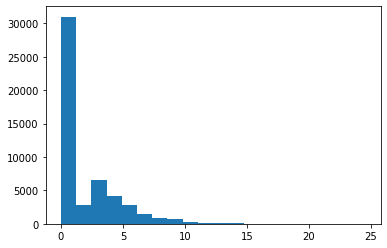

In [50]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(variance_of_data['all'], bins=20)

(array([2.0646e+04, 7.5150e+03, 3.3020e+03, 1.2140e+03, 3.5900e+02,
        1.0200e+02, 3.3000e+01, 1.2000e+01, 1.0000e+01, 5.0000e+00]),
 array([ 0.        ,  2.45454545,  4.90909091,  7.36363636,  9.81818182,
        12.27272727, 14.72727273, 17.18181818, 19.63636364, 22.09090909,
        24.54545455]),
 <BarContainer object of 10 artists>)

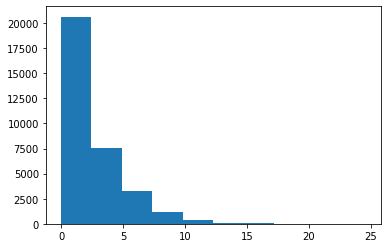

In [46]:
plt.hist(variance_of_data['zh-en'])

In [17]:
DATA_HOME = '/ahc/work3/kosuke-t'
LANGWO_LETTERS = 'LANGWO'
LANG_LETTERS = 'L_A_N_G'
LANG1_LETTERS = 'LANG1'
LANG2_LETTERS = 'LANG2'
SYSTEM_LETTERS = 'SYSTEM'
src_21_files = os.path.join(DATA_HOME, 'WMT/WMT21-data/sources/newstest2021.{}.src.{}'.format(LANG_LETTERS, LANG1_LETTERS))
ref_21_files = os.path.join(DATA_HOME, 'WMT/WMT21-data/references/newstest2021.{}.ref.ref-A.{}'.format(LANG_LETTERS, LANG2_LETTERS))
hyp_21_files =  os.path.join(DATA_HOME, 'WMT/WMT21-data/system-outputs/newstest2021/{}/newstest2021.{}.hyp.{}.en'.format(LANG_LETTERS, LANG_LETTERS, SYSTEM_LETTERS, LANG2_LETTERS))
MQM_avg_21_files = os.path.join(DATA_HOME, 'WMT/wmt-mqm-human-evaluation/newstest2021/{}/mqm_newstest2021_{}.avg_seg_scores.tsv'.format(LANGWO_LETTERS, LANGWO_LETTERS))
MQM_tag_21_files = os.path.join(DATA_HOME, 'WMT/wmt-mqm-human-evaluation/newstest2021/{}/mqm_newstest2021_{}.tsv'.format(LANGWO_LETTERS, LANGWO_LETTERS))
                               # project_disc/WMT/wmt-mqm-human-evaluation/newstest2021/ende/mqm_newstest2021_ende.tsv
class MQM_importer21(MQM_importer20):
    def __init__(self, save_dir, mqm_tag=False, avg=False, emb_label=False, emb_only_sev=True, no_error_score=np.asarray([1, 0, 0]),
                 tokenizer_name='xlm-roberta-large', original_score=True, split_dev=False, dev_ratio=0.1):
        super(MQM_importer21, self).__init__(save_dir, 
                                             mqm_tag,
                                             avg,
                                             emb_label,
                                             emb_only_sev,
                                             no_error_score,
                                             tokenizer_name=tokenizer_name,
                                             original_score=original_score,
                                             split_dev=split_dev,
                                             dev_ratio=dev_ratio)
        self.year = '21'
        
    def parse_eval_file_name(self, fname):
        """Extracts language pairs from the names of human rating files."""
        wmt_pattern = re.compile(r"^ad-seg-scores-([a-z]{2}-[a-z]{2})\.csv")
        match = re.match(wmt_pattern, fname)
        if match:
            return match.group(1)
        else:
            return None

    def get_src_ref(self, lang):
        src_lang = lang[:2]
        tgt_lang = lang[-2:]
        src_file = src_21_files.replace(LANG_LETTERS, lang).replace(LANG1_LETTERS, src_lang)
        ref_file = ref_21_files.replace(LANG_LETTERS, lang).replace(LANG2_LETTERS, tgt_lang)
        
        with open(src_file, "r", encoding="utf-8") as f_src:
            src_segments = f_src.readlines()
        with open(ref_file, "r", encoding="utf-8") as f_ref:
            ref_segments = f_ref.readlines()

        src_segments = [s.strip() for s in src_segments]
        ref_segments = [s.strip() for s in ref_segments]

        return src_segments, ref_segments
    
    def get_sys(self, lang):
        sys_segments = {}
        src_lang = lang[:2]
        tgt_lang = lang[-2:]
        folder = '/home/is/kosuke-t/project_disc/WMT/wmt21-news-systems/txt/system-outputs'
        paths = os.path.join(folder, "newstest2021.{}.hyp.*.{}".format(lang, tgt_lang))
        all_files = glob.glob(paths)
        for fname in all_files:
            fname_base = os.path.basename(fname)
            sys_name = re.sub(r'newstest2021\.|{}\.hyp\.|\.{}'.format(lang, tgt_lang), '',fname_base)
            with open(fname, mode='r', encoding='utf-8') as r:
                data = r.readlines()
            data = [d.strip() for d in data]
            sys_segments[sys_name] = data
        return sys_segments
    
    def get_MQM(self, lang):
        lang_wo = lang.replace('-', '')
        if not self.mqm_tag:
            fname = os.path.join('/ahc/work3/kosuke-t/WMT/wmt-mqm-human-evaluation/newstest2021',
                                 lang_wo, 'mqm_newstest2021_{}.avg_seg_scores.tsv'.format(lang_wo))
                
        else:
            fname = os.path.join('/ahc/work3/kosuke-t/WMT/wmt-mqm-human-evaluation/newstest2021',
                             lang_wo, 'mqm_newstest2021_{}.tsv'.format(lang_wo))
        
        with open(fname, mode='r', encoding='utf-8') as r:
            data = r.readlines()
        return data
    
    def organize_mqm_tag(self, MQM_data, src_segments):
        rater_dic = {}
        for line in MQM_data[1:]:
            sys_name, seg_id, rater, source, target, category, severity = self.parse_rating(line)
            if sys_name == 'Nemo':
                sys_name = 'NVIDIA-NeMo'
            elif sys_name in ['metricsystem1', 'metricsystem2', 'metricsystem3', 'metricsystem4', 'metricsystem5', 
                              'ref-A', 'ref-B', 'ref-C', 'ref-D']:
                continue
            seg_id = int(seg_id)
            untagged_hyp = self.get_untagged_hyp(target)
            key = (sys_name, seg_id, untagged_hyp)
            if key not in rater_dic:
                rater_dic[key] = {'rater':[], 'target':[], 'category':[], 'severity':[]}
            rater_dic[key]['rater'].append(rater)
            rater_dic[key]['target'].append(target)
            rater_dic[key]['category'].append(category)
            rater_dic[key]['severity'].append(severity)
            rater_dic[key]['seg_id'] = seg_id
            rater_dic[key]['sys_name'] = sys_name
            rater_dic[key]['untagged_hyp'] = untagged_hyp
            
            if 'source' in rater_dic[key]:
                continue
            if source != src_segments[seg_id-1]:
                min_lv_seg_id = 0
                min_lv_value = 1000
                for idx, s in enumerate(src_segments):
                    lv_value = levenshtein(source, s)
                    if lv_value < min_lv_value:
                        min_lv_value = lv_value
                        min_lv_seg_id = idx
                if seg_id-1 != min_lv_seg_id:
                    rater_dic[key]['source'] = src_segments[min_lv_seg_id]
                else:
                    rater_dic[key]['source'] = src_segments[min_lv_seg_id]
            else:
                rater_dic[key]['source'] = source
        return rater_dic
    
#     def make_MQM(self):
#         size_of_data = {lang:0 for lang in self.list_lang_pairs()}
#         variance_of_data = {lang:[] for lang in self.list_lang_pairs()}
#         variance_of_data['all'] = []
#         for lang in self.list_lang_pairs():
#             src_segments, ref_segments = self.get_src_ref(lang)
#             sys_segments = self.get_sys(lang)
#             MQM_data = self.get_MQM(lang)
#             with open(self.save_tmp, mode='w+', encoding='utf-8') as w:
#                 if self.mqm_tag:
#                     rater_dic = self.organize_mqm_tag(MQM_data, src_segments)
#                     size_of_data[lang] = len(rater_dic)
#                     if self.avg:
#                         for key in rater_dic.keys():
#                             scores = []
#                             for idx in range(len(rater_dic[key]['rater'])):
#                                 scores.append(self.get_mqm_tagged_score(rater_dic[key]['category'][idx], rater_dic[key]['severity'][idx]))
#                             rater_dic[key]['score'] = np.mean(scores)
#                             rater_dic[key]['variance'] = sum([(s-np.mean(scores))**2 for s in scores])
#                             variance_of_data[lang].append(rater_dic[key]['variance'])
#                             variance_of_data['all'].append(rater_dic[key]['variance'])
#                     else:
#                         for i, key in enumerate(rater_dic.keys()):
#                             score_tag = []
#                             scores = []
#                             for idx in range(len(rater_dic[key]['rater'])):
#                                 tagged_hyp = rater_dic[key]['target'][idx]
#                                 category = rater_dic[key]['category'][idx]
#                                 severity = rater_dic[key]['severity'][idx]
#                                 if len(score_tag) == 0:
#                                     score_tag = np.asarray(self.get_scored_token(tagged_hyp, category, severity), dtype=np.float64)
#                                 else:
#                                     score_tag += np.asarray(self.get_scored_token(tagged_hyp, category, severity), dtype=np.float64)
#                                 scores.append(self.get_mqm_tagged_score(category, severity))
#                             rater_dic[key]['variance'] = sum([(s-np.mean(scores))**2 for s in scores])
#                             variance_of_data[lang].append(rater_dic[key]['variance'])
#                             variance_of_data['all'].append(rater_dic[key]['variance'])
#                             rater_dic[key]['score'] = score_tag.tolist()
#                     for key in rater_dic.keys():
#                         seg_id = rater_dic[key]['seg_id']
#                         sys_name = rater_dic[key]['sys_name']
#                         ref_segment = ref_segments[seg_id-1]
#                         src_segment = rater_dic[key]['source']
#                         sys_segment = rater_dic[key]['untagged_hyp']
#                         score = rater_dic[key]['score']
#                         variance = rater_dic[key]['variance']
#                         example = self.to_MQM_json(self.year, lang, 
#                                                    src_segment, ref_segment, 'ref-A',
#                                                    sys_segment, score,
#                                                    seg_id, sys_name, variance)
#                         w.write(example)
#                         w.write("\n")
#                         size_of_data[lang] += 1
#                 else:        
#                     for line in MQM_data[1:]:
#                         sys_name, seg_id, score = self.parse_rating(line)
#                         if score == None:
#                             continue
#                         src_segment = src_segments[seg_id-1]
#                         ref_segment = ref_segments[seg_id-1]

#                         try:
#                             if sys_name == 'Nemo':
#                                 sys_name = 'NVIDIA-NeMo'
#                             elif sys_name in ['metricsystem1', 'metricsystem2', 'metricsystem3', 'metricsystem4', 'metricsystem5', 
#                                               'ref-A', 'ref-B', 'ref-C', 'ref-D']:
#                                 continue
#                             sys_segment = sys_segments[sys_name][seg_id-1]
#                         except:
#                             if not sys_name in dic_of_sys:
#                                 dic_of_sys[sys_name] = sys_segments.keys()
#                                 print(sys_name)
#                                 print(sys_segments.keys())
#                         example = self.to_json('20', lang, src_segment, 
#                                                ref_segment, 'ref-A', sys_segment, 0, 
#                                                score, seg_id, sys_name, 0)
#                         w.write(example)
#                         w.write("\n")
#                         size_of_data[lang] += 1
#         print(size_of_data)
#         return variance_of_data
    
# importer = MQM_importer21('/ahc/work3/kosuke-t/WMT/wmt21_mqm_averaged.json',
#                           mqm_tag=False, avg=True, original_score=True, split_dev=True)
# variance_of_data = importer.make_MQM()
# importer.postprocess()

importer = MQM_importer21('/ahc/work3/kosuke-t/WMT/wmt21_mqm_my_averaged.json',
                          mqm_tag=True, avg=True, original_score=True, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

importer = MQM_importer21('/ahc/work3/kosuke-t/WMT/wmt21_mqm_tagged_xlm-roberta-large.json',
                          mqm_tag=True, avg=False, original_score=True, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

importer = MQM_importer21('/ahc/work3/kosuke-t/WMT/wmt21_mqm_tagged_score_adjusted_xlm-roberta-large.json',
                          mqm_tag=True, avg=False, original_score=False, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

importer = MQM_importer21('/ahc/work3/kosuke-t/WMT/wmt21_mqm_emb_label_only_severity_xlm-roberta-large.json',
                          mqm_tag=True, avg=False, emb_label=True, emb_only_sev=True, no_error_score=np.asarray([1, 0, 0]), original_score=False, split_dev=True)
variance_of_data = importer.make_MQM()
importer.postprocess()

No-error
10
('hyp.Facebook-AI', 'abcnews.420140', '1', '715', 'rater2', 'UN says thousands of anti-Pakistan militants in Afghanistan', 'UN: Tausende militante Anti-Pakistan-Kämpfer in Afghanistan', 'No-error', 'No-error', '\n')
hyp.Facebook-AI	abcnews.420140	1	715	rater2	UN says thousands of anti-Pakistan militants in Afghanistan	UN: Tausende militante Anti-Pakistan-Kämpfer in Afghanistan	No-error	No-error	



UnboundLocalError: local variable 'severity' referenced before assignment